In [1]:
import pandas as pd
from pandas.core.computation.check import NUMEXPR_INSTALLED
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error
import time
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, GridSearchCV


/Users/sunny/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# reading in preprocessed csv
jobdf = pd.read_csv('Data/job_df_preprocessed.csv', index_col = 'job_id')

# setting up data for use in elastic net
jobdf.drop(columns = ['Unnamed: 0'], inplace = True)
# print(jobdf)
X = jobdf.drop(['fraudulent'], axis = 1)
y = jobdf['fraudulent']

to_norm_x = X

X = (to_norm_x - to_norm_x.mean())/to_norm_x.std()
X__ = pd.concat([X, y], axis=1)

test = X__.sample(frac=0.2, axis=0)
train = X__.drop(index=test.index)

# we will resample the data for elastic net, this split is only for use in elastic net
Xtrain = train.drop(['fraudulent'], axis = 1)
ytrain = train['fraudulent']

Xtest = test.drop(['fraudulent'], axis = 1)
ytest = test['fraudulent']

# creating the scaler

scaler = StandardScaler().fit(Xtrain)


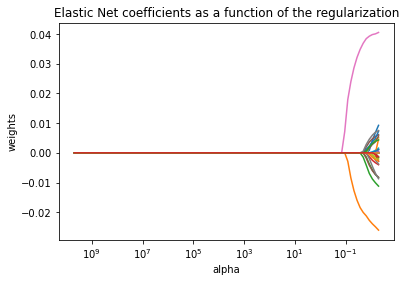

In [16]:
# elastic net variable selection

alphas = 10**np.linspace(10,-2,100)*0.5
l1_ratio = 0.5

en = ElasticNet(max_iter=10000)
coefs = []

for a in alphas:
    en.set_params(alpha=a, l1_ratio=l1_ratio)
    en.fit(scale(X), y)
    coefs.append(en.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic Net coefficients as a function of the regularization');



In [17]:
# As we can see with our data quite a bit of it gets knocked out, which means that
# we have a lot of noise within the data. Now that we have identified that elastic
# net is going to be useful, let's run it more in depth and get optimal values for
# l1 and l2.

In [20]:
folds = np.random.choice(a = 10, size = Xtrain.shape[0])
alphas = np.linspace(0.01,5,50)
l1_ratio = np.linspace(0.01,1,50)

# I chose 50 increments because I felt like that would give me a better idea of
# the optimal values for lambda and l1_ratio.

mse_list = []
alpha_list = []
l1_list = []
for alpha in alphas:
    for l1 in l1_ratio:
        cv_list = []
        for i in range(10):
            val_folds_X = Xtrain.iloc[np.where(folds == i)]
            train_folds_X = Xtrain.iloc[np.where(folds != i)]

            val_folds_y = ytrain.iloc[np.where(folds == i)]
            train_folds_y = ytrain.iloc[np.where(folds != i)]

            encv = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
            encv.fit(scaler.transform(train_folds_X), train_folds_y)
            pred = encv.predict(scaler.transform(val_folds_X))
            cv_list.append(mean_squared_error(val_folds_y, pred))
        mse_list.append(np.mean(cv_list))
        alpha_list.append(alpha)
        l1_list.append(l1)


In [23]:
opt_lambda = alpha_list[np.argmin(mse_list)]
opt_l1 = l1_list[np.argmin(mse_list)]
print(opt_lambda, opt_l1)

0.01 0.01


In [ ]:
# what the opt_lambda of 0.01 tells us is that most of the focus should be placed on
# the RSS with only 0.01 of that on the elastic net.

# what the opt_l1 tells us is that approximately 0.01 of the elastic net is 
# doing Lasso and 0.99 doing Ridge.

In [26]:
opt_en = ElasticNet()
opt_en.set_params(alpha=opt_lambda, l1_ratio=opt_l1, max_iter=10000)
opt_en.fit(scaler.transform(Xtrain), ytrain)
mean_squared_error(ytest, opt_en.predict(scaler.transform(Xtest)))

0.0440428525987354

In [ ]:
# the MSE of 0.0440428525987354 I would say is fairly decent. This means that
# the average squared difference between the estimated values and the actual value
# is only 0.04

In [27]:
# shows the coefficients for the elatic net, 0.000000 means that it has been
# taken out because the elastic net deemed it noise.

# negative coefficients suggest that it trends more towards fradulent being FALSE.
# That is because pandas treats TRUE/FALSE columns as a boolean vector of 1/0.

pd.Series(opt_en.coef_.flatten(), index=X.columns)

telecommuting                          0.003751
has_company_logo                      -0.027878
has_questions                         -0.011199
has_salary_range                      -0.006493
has_location                           0.002660
has_department                        -0.011704
has_company_profile                    0.044434
has_requirements                      -0.012497
has_benefits                          -0.004980
has_employment_type                    0.003848
has_required_experience                0.019106
has_required_education                 0.018207
has_industry                          -0.010950
has_function                          -0.008306
description_word_count                -0.002985
title_word_count                       0.006377
company_profile_word_count            -0.002880
requirements_word_count               -0.007860
benefits_word_count                    0.008541
required_experience_word_count         0.002039
required_education_word_count          0

In [ ]:
# It seems that everything is left in and important to prediction. This is mostly
# due to the 0.99 from the ridge ratio. Due to this, I will determine what is useful
# using the varimp plots during random forests.

In [35]:
# reformatting the data for use ml algos

# train/val/test split

# for the purpose of this analysis, to not overfit to the test set, we will
# only be predicting on the test set once the best model has been found at the end.

X = jobdf.drop(['fraudulent'], axis = 1)
y = jobdf['fraudulent']

X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size = 0.7)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size = 0.5)

print(X_val.shape, X_test.shape, X_train.shape)
print(y_val.shape, y_test.shape, y_train.shape)


(2682, 34) (2682, 34) (12515, 34)
(2682,) (2682,) (12515,)


In [40]:
# majority classifier

print(Counter(y))

print(17014/(865+17014))

# for this data, anything above 0.9516 we have learned something and would be
# better off than taking the majority classifier.


Counter({0: 17014, 1: 865})
0.9516192180770736


In [ ]:
# due to the huge class inbalance within the data, it would be good to upsample
# the minority classifier

In [3]:
real = jobdf[jobdf["fraudulent"] == 0]
fraud = jobdf[jobdf["fraudulent"] == 1]

fraud_upsample = resample(fraud,
             replace = True,
             n_samples = len(real))

data_upsampled = pd.concat([real, fraud_upsample])

X = data_upsampled.drop(['fraudulent'], axis = 1)
y = data_upsampled['fraudulent']

X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size = 0.7)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size = 0.5)

print(X_val.shape, X_test.shape, X_train.shape)
print(y_val.shape, y_test.shape, y_train.shape)

(5104, 34) (5105, 34) (23819, 34)
(5104,) (5105,) (23819,)


In [133]:
# majority classifier (after upsampling)

print(Counter(y))

print(17014/(17014+17014))

# now that the data is evenly distributed, let's begin on running models.

Counter({0: 17014, 1: 17014})
0.5


In [134]:
# random forest baseline

t0 = time.time()
forest = RandomForestClassifier(n_estimators=100, oob_score=True).fit(X_train, y_train)
t1 = time.time()

print("Time to fit and get OOB score: " + str(t1-t0) + "s")
print("Average OOB Accuracy: " + str(np.round(forest.oob_score_*100,2)) + "%")
print("Val Accuracy: " + str(np.round(forest.score(X_val,y_val)*100,2)) + "%")

Time to fit and get OOB score: 1.5971579551696777s
Average OOB Accuracy: 99.68%
Val Accuracy: 99.69%


In [53]:
# varimp in python, not as pretty as R

feature_labels = X_train.columns
importances = forest.feature_importances_

sorted_indices = importances.argsort()[::-1]

print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. {feature_labels[i]} ({importances[sorted_indices[i]]:.3f})")

Feature ranking:
1. telecommuting (0.167)
2. has_company_logo (0.114)
3. has_questions (0.080)
4. has_salary_range (0.067)
5. has_location (0.067)
6. has_department (0.066)
7. has_company_profile (0.054)
8. has_requirements (0.050)
9. has_benefits (0.042)
10. has_employment_type (0.037)
11. has_required_experience (0.031)
12. has_required_education (0.030)
13. has_industry (0.029)
14. has_function (0.024)
15. description_word_count (0.021)
16. title_word_count (0.020)
17. company_profile_word_count (0.011)
18. requirements_word_count (0.011)
19. benefits_word_count (0.010)
20. required_experience_word_count (0.009)
21. required_education_word_count (0.007)
22. avg_sentence_length_description (0.007)
23. avg_sentence_length_requirements (0.007)
24. avg_sentence_length_experience (0.006)
25. avg_sentence_length_company_profile (0.006)
26. avg_sentence_length_education (0.005)
27. avg_sentence_length_benefits (0.005)
28. description_num_suspicious_words (0.004)
29. employment_type_Contrac

In [135]:
# cut out some of the variables:

X_train_cut = X_train.drop(columns = ['required_experience_word_count',
                                      'required_education_word_count',
                                      'avg_sentence_length_description',
                                      'avg_sentence_length_experience',
                                      'avg_sentence_length_company_profile',
                                      'avg_sentence_length_education',
                                      'avg_sentence_length_benefits',
                                      'description_num_suspicious_words',
                                      'employment_type_Contract',
                                      'employment_type_Full-time',
                                      'employment_type_Missing',
                                      'employment_type_Other',
                                      'employment_type_Part-time',
                                      'employment_type_Temporary'])

X_val_cut = X_val.drop(columns = ['required_experience_word_count',
                                  'required_education_word_count',
                                  'avg_sentence_length_description',
                                  'avg_sentence_length_experience',
                                  'avg_sentence_length_company_profile',
                                  'avg_sentence_length_education',
                                  'avg_sentence_length_benefits',
                                  'description_num_suspicious_words',
                                  'employment_type_Contract',
                                  'employment_type_Full-time',
                                  'employment_type_Missing',
                                  'employment_type_Other',
                                  'employment_type_Part-time',
                                  'employment_type_Temporary'])



In [136]:
t0 = time.time()
forest = RandomForestClassifier(n_estimators=100, oob_score=True).fit(X_train_cut, y_train)
t1 = time.time()

print("Time to fit and get OOB score: " + str(t1-t0) + "s")
print("Average OOB Accuracy: " + str(np.round(forest.oob_score_*100,2)) + "%")
print("Val Accuracy: " + str(np.round(forest.score(X_val_cut,y_val)*100,2)) + "%")


Time to fit and get OOB score: 1.197476863861084s
Average OOB Accuracy: 99.64%
Val Accuracy: 99.49%


In [ ]:
# since it is still that high, I'm going to drop more variables until it starts
# making an actual difference and the back off to the optimal number of variables
# for the model.

In [4]:
# dropping more variables:

X_train_cut = X_train.drop(columns = ['requirements_word_count',
                                      'benefits_word_count',
                                      'required_experience_word_count',
                                      'required_education_word_count',
                                      'avg_sentence_length_description',
                                      'avg_sentence_length_experience',
                                      'avg_sentence_length_company_profile',
                                      'avg_sentence_length_education',
                                      'avg_sentence_length_benefits',
                                      'description_num_suspicious_words',
                                      'employment_type_Contract',
                                      'employment_type_Full-time',
                                      'employment_type_Missing',
                                      'employment_type_Other',
                                      'employment_type_Part-time',
                                      'employment_type_Temporary'])

X_val_cut = X_val.drop(columns = ['requirements_word_count',
                                  'benefits_word_count',
                                  'required_experience_word_count',
                                  'required_education_word_count',
                                  'avg_sentence_length_description',
                                  'avg_sentence_length_experience',
                                  'avg_sentence_length_company_profile',
                                  'avg_sentence_length_education',
                                  'avg_sentence_length_benefits',
                                  'description_num_suspicious_words',
                                  'employment_type_Contract',
                                  'employment_type_Full-time',
                                  'employment_type_Missing',
                                  'employment_type_Other',
                                  'employment_type_Part-time',
                                  'employment_type_Temporary'])

X_test_cut = X_test.drop(columns = ['requirements_word_count',
                                    'benefits_word_count',
                                    'required_experience_word_count',
                                    'required_education_word_count',
                                    'avg_sentence_length_description',
                                    'avg_sentence_length_experience',
                                    'avg_sentence_length_company_profile',
                                    'avg_sentence_length_education',
                                    'avg_sentence_length_benefits',
                                    'description_num_suspicious_words',
                                    'employment_type_Contract',
                                    'employment_type_Full-time',
                                    'employment_type_Missing',
                                    'employment_type_Other',
                                    'employment_type_Part-time',
                                    'employment_type_Temporary'])


In [149]:
t0 = time.time()
forest = RandomForestClassifier(n_estimators=100, oob_score=True).fit(X_train_cut, y_train)
t1 = time.time()

print("Time to fit and get OOB score: " + str(t1-t0) + "s")
print("Average OOB Accuracy: " + str(np.round(forest.oob_score_*100,2)) + "%")
print("Val Accuracy: " + str(np.round(forest.score(X_val_cut,y_val)*100,2)) + "%")

Time to fit and get OOB score: 1.1472969055175781s
Average OOB Accuracy: 99.44%
Val Accuracy: 99.31%


In [140]:
# with 16 of the variables discarded (18 retained), the model only suffered a tiny 
# dip in validation accuracy. I would say that this model is an extremely good baseline
# to use. Now that the random forest baseline of 99.31% on the validation set
# has been created, let's see if we can get any better models with the remaining
# boosting, SVM, and neural networks.

In [115]:
# gradient boosting

# We decided to focus on gradient boosting instead of adaboosting because from 
# prior analyses, gradient boosting has performed better in a large majority of cases.

num_trees = np.arange(1, 60, 1)
learning_rates = np.linspace(0.1,2,21)
depths = np.arange(1, 16, 1)
val_acc_list = []
hyperparameter_combo = []

for n in num_trees:
    for lr in learning_rates:
        for d in depths:
            boost = GradientBoostingClassifier(n_estimators=n, learning_rate=lr,
                                        max_depth=d, random_state=0).fit(X_train_cut, y_train)
    
            val_acc_list.append(boost.score(X_val_cut, y_val))
            print(f'Completed tree {n} and learning rate of {lr} and depth of {d}')
            hyperparameter_combo.append((n,lr,d))


Completed tree 1 and learning rate of 0.1 and depth of 1
Completed tree 1 and learning rate of 0.1 and depth of 2
Completed tree 1 and learning rate of 0.1 and depth of 3
Completed tree 1 and learning rate of 0.1 and depth of 4
Completed tree 1 and learning rate of 0.1 and depth of 5
Completed tree 1 and learning rate of 0.1 and depth of 6
Completed tree 1 and learning rate of 0.1 and depth of 7
Completed tree 1 and learning rate of 0.1 and depth of 8
Completed tree 1 and learning rate of 0.1 and depth of 9
Completed tree 1 and learning rate of 0.1 and depth of 10
Completed tree 1 and learning rate of 0.1 and depth of 11
Completed tree 1 and learning rate of 0.1 and depth of 12
Completed tree 1 and learning rate of 0.1 and depth of 13
Completed tree 1 and learning rate of 0.1 and depth of 14
Completed tree 1 and learning rate of 0.1 and depth of 15
Completed tree 1 and learning rate of 0.195 and depth of 1
Completed tree 1 and learning rate of 0.195 and depth of 2
Completed tree 1 and 

Completed tree 1 and learning rate of 0.955 and depth of 3
Completed tree 1 and learning rate of 0.955 and depth of 4
Completed tree 1 and learning rate of 0.955 and depth of 5
Completed tree 1 and learning rate of 0.955 and depth of 6
Completed tree 1 and learning rate of 0.955 and depth of 7
Completed tree 1 and learning rate of 0.955 and depth of 8
Completed tree 1 and learning rate of 0.955 and depth of 9
Completed tree 1 and learning rate of 0.955 and depth of 10
Completed tree 1 and learning rate of 0.955 and depth of 11
Completed tree 1 and learning rate of 0.955 and depth of 12
Completed tree 1 and learning rate of 0.955 and depth of 13
Completed tree 1 and learning rate of 0.955 and depth of 14
Completed tree 1 and learning rate of 0.955 and depth of 15
Completed tree 1 and learning rate of 1.05 and depth of 1
Completed tree 1 and learning rate of 1.05 and depth of 2
Completed tree 1 and learning rate of 1.05 and depth of 3
Completed tree 1 and learning rate of 1.05 and depth 

Completed tree 1 and learning rate of 1.715 and depth of 9
Completed tree 1 and learning rate of 1.715 and depth of 10
Completed tree 1 and learning rate of 1.715 and depth of 11
Completed tree 1 and learning rate of 1.715 and depth of 12
Completed tree 1 and learning rate of 1.715 and depth of 13
Completed tree 1 and learning rate of 1.715 and depth of 14
Completed tree 1 and learning rate of 1.715 and depth of 15
Completed tree 1 and learning rate of 1.81 and depth of 1
Completed tree 1 and learning rate of 1.81 and depth of 2
Completed tree 1 and learning rate of 1.81 and depth of 3
Completed tree 1 and learning rate of 1.81 and depth of 4
Completed tree 1 and learning rate of 1.81 and depth of 5
Completed tree 1 and learning rate of 1.81 and depth of 6
Completed tree 1 and learning rate of 1.81 and depth of 7
Completed tree 1 and learning rate of 1.81 and depth of 8
Completed tree 1 and learning rate of 1.81 and depth of 9
Completed tree 1 and learning rate of 1.81 and depth of 10


Completed tree 2 and learning rate of 0.575 and depth of 10
Completed tree 2 and learning rate of 0.575 and depth of 11
Completed tree 2 and learning rate of 0.575 and depth of 12
Completed tree 2 and learning rate of 0.575 and depth of 13
Completed tree 2 and learning rate of 0.575 and depth of 14
Completed tree 2 and learning rate of 0.575 and depth of 15
Completed tree 2 and learning rate of 0.67 and depth of 1
Completed tree 2 and learning rate of 0.67 and depth of 2
Completed tree 2 and learning rate of 0.67 and depth of 3
Completed tree 2 and learning rate of 0.67 and depth of 4
Completed tree 2 and learning rate of 0.67 and depth of 5
Completed tree 2 and learning rate of 0.67 and depth of 6
Completed tree 2 and learning rate of 0.67 and depth of 7
Completed tree 2 and learning rate of 0.67 and depth of 8
Completed tree 2 and learning rate of 0.67 and depth of 9
Completed tree 2 and learning rate of 0.67 and depth of 10
Completed tree 2 and learning rate of 0.67 and depth of 11


Completed tree 2 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 2 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 2 and learning rate of 1.5250000000000001 and depth of 1
Completed tree 2 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 2 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 2 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 2 and learning rate of 1.5250000000000001 a

Completed tree 3 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 13
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 3 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 3 and learning rate of 0.385 and depth of 1
Completed tree 3 and learning rate of 0.385 and depth of 2
Completed tree 3 and learning rate of 0.385 and depth of 3
Completed tree 3 and learning rate of 0.385 and depth of 4
Completed tree 3 and learning rate of 0.385 and depth of 5
Completed tree 3 and learning rate of 0.385 and depth of 6
Completed tree 3 and learning rate of 0.385 and depth of

Completed tree 3 and learning rate of 1.145 and depth of 12
Completed tree 3 and learning rate of 1.145 and depth of 13
Completed tree 3 and learning rate of 1.145 and depth of 14
Completed tree 3 and learning rate of 1.145 and depth of 15
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 3
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 7
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 8
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 3 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 3 and learning rate of 1

Completed tree 3 and learning rate of 2.0 and depth of 4
Completed tree 3 and learning rate of 2.0 and depth of 5
Completed tree 3 and learning rate of 2.0 and depth of 6
Completed tree 3 and learning rate of 2.0 and depth of 7
Completed tree 3 and learning rate of 2.0 and depth of 8
Completed tree 3 and learning rate of 2.0 and depth of 9
Completed tree 3 and learning rate of 2.0 and depth of 10
Completed tree 3 and learning rate of 2.0 and depth of 11
Completed tree 3 and learning rate of 2.0 and depth of 12
Completed tree 3 and learning rate of 2.0 and depth of 13
Completed tree 3 and learning rate of 2.0 and depth of 14
Completed tree 3 and learning rate of 2.0 and depth of 15
Completed tree 4 and learning rate of 0.1 and depth of 1
Completed tree 4 and learning rate of 0.1 and depth of 2
Completed tree 4 and learning rate of 0.1 and depth of 3
Completed tree 4 and learning rate of 0.1 and depth of 4
Completed tree 4 and learning rate of 0.1 and depth of 5
Completed tree 4 and lear

Completed tree 4 and learning rate of 0.86 and depth of 6
Completed tree 4 and learning rate of 0.86 and depth of 7
Completed tree 4 and learning rate of 0.86 and depth of 8
Completed tree 4 and learning rate of 0.86 and depth of 9
Completed tree 4 and learning rate of 0.86 and depth of 10
Completed tree 4 and learning rate of 0.86 and depth of 11
Completed tree 4 and learning rate of 0.86 and depth of 12
Completed tree 4 and learning rate of 0.86 and depth of 13
Completed tree 4 and learning rate of 0.86 and depth of 14
Completed tree 4 and learning rate of 0.86 and depth of 15
Completed tree 4 and learning rate of 0.955 and depth of 1
Completed tree 4 and learning rate of 0.955 and depth of 2
Completed tree 4 and learning rate of 0.955 and depth of 3
Completed tree 4 and learning rate of 0.955 and depth of 4
Completed tree 4 and learning rate of 0.955 and depth of 5
Completed tree 4 and learning rate of 0.955 and depth of 6
Completed tree 4 and learning rate of 0.955 and depth of 7
C

Completed tree 4 and learning rate of 1.62 and depth of 12
Completed tree 4 and learning rate of 1.62 and depth of 13
Completed tree 4 and learning rate of 1.62 and depth of 14
Completed tree 4 and learning rate of 1.62 and depth of 15
Completed tree 4 and learning rate of 1.715 and depth of 1
Completed tree 4 and learning rate of 1.715 and depth of 2
Completed tree 4 and learning rate of 1.715 and depth of 3
Completed tree 4 and learning rate of 1.715 and depth of 4
Completed tree 4 and learning rate of 1.715 and depth of 5
Completed tree 4 and learning rate of 1.715 and depth of 6
Completed tree 4 and learning rate of 1.715 and depth of 7
Completed tree 4 and learning rate of 1.715 and depth of 8
Completed tree 4 and learning rate of 1.715 and depth of 9
Completed tree 4 and learning rate of 1.715 and depth of 10
Completed tree 4 and learning rate of 1.715 and depth of 11
Completed tree 4 and learning rate of 1.715 and depth of 12
Completed tree 4 and learning rate of 1.715 and depth

Completed tree 5 and learning rate of 0.48 and depth of 13
Completed tree 5 and learning rate of 0.48 and depth of 14
Completed tree 5 and learning rate of 0.48 and depth of 15
Completed tree 5 and learning rate of 0.575 and depth of 1
Completed tree 5 and learning rate of 0.575 and depth of 2
Completed tree 5 and learning rate of 0.575 and depth of 3
Completed tree 5 and learning rate of 0.575 and depth of 4
Completed tree 5 and learning rate of 0.575 and depth of 5
Completed tree 5 and learning rate of 0.575 and depth of 6
Completed tree 5 and learning rate of 0.575 and depth of 7
Completed tree 5 and learning rate of 0.575 and depth of 8
Completed tree 5 and learning rate of 0.575 and depth of 9
Completed tree 5 and learning rate of 0.575 and depth of 10
Completed tree 5 and learning rate of 0.575 and depth of 11
Completed tree 5 and learning rate of 0.575 and depth of 12
Completed tree 5 and learning rate of 0.575 and depth of 13
Completed tree 5 and learning rate of 0.575 and dept

Completed tree 5 and learning rate of 1.3350000000000002 and depth of 12
Completed tree 5 and learning rate of 1.3350000000000002 and depth of 13
Completed tree 5 and learning rate of 1.3350000000000002 and depth of 14
Completed tree 5 and learning rate of 1.3350000000000002 and depth of 15
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 1
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 2
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 6
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 5 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 5 and learning rate of 1.4300000000000002 and

Completed tree 6 and learning rate of 0.195 and depth of 10
Completed tree 6 and learning rate of 0.195 and depth of 11
Completed tree 6 and learning rate of 0.195 and depth of 12
Completed tree 6 and learning rate of 0.195 and depth of 13
Completed tree 6 and learning rate of 0.195 and depth of 14
Completed tree 6 and learning rate of 0.195 and depth of 15
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 2
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 3
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 5
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 6 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 6 and learning rate of 0.2900000000000000

Completed tree 6 and learning rate of 1.05 and depth of 11
Completed tree 6 and learning rate of 1.05 and depth of 12
Completed tree 6 and learning rate of 1.05 and depth of 13
Completed tree 6 and learning rate of 1.05 and depth of 14
Completed tree 6 and learning rate of 1.05 and depth of 15
Completed tree 6 and learning rate of 1.145 and depth of 1
Completed tree 6 and learning rate of 1.145 and depth of 2
Completed tree 6 and learning rate of 1.145 and depth of 3
Completed tree 6 and learning rate of 1.145 and depth of 4
Completed tree 6 and learning rate of 1.145 and depth of 5
Completed tree 6 and learning rate of 1.145 and depth of 6
Completed tree 6 and learning rate of 1.145 and depth of 7
Completed tree 6 and learning rate of 1.145 and depth of 8
Completed tree 6 and learning rate of 1.145 and depth of 9
Completed tree 6 and learning rate of 1.145 and depth of 10
Completed tree 6 and learning rate of 1.145 and depth of 11
Completed tree 6 and learning rate of 1.145 and depth 

Completed tree 6 and learning rate of 1.905 and depth of 4
Completed tree 6 and learning rate of 1.905 and depth of 5
Completed tree 6 and learning rate of 1.905 and depth of 6
Completed tree 6 and learning rate of 1.905 and depth of 7
Completed tree 6 and learning rate of 1.905 and depth of 8
Completed tree 6 and learning rate of 1.905 and depth of 9
Completed tree 6 and learning rate of 1.905 and depth of 10
Completed tree 6 and learning rate of 1.905 and depth of 11
Completed tree 6 and learning rate of 1.905 and depth of 12
Completed tree 6 and learning rate of 1.905 and depth of 13
Completed tree 6 and learning rate of 1.905 and depth of 14
Completed tree 6 and learning rate of 1.905 and depth of 15
Completed tree 6 and learning rate of 2.0 and depth of 1
Completed tree 6 and learning rate of 2.0 and depth of 2
Completed tree 6 and learning rate of 2.0 and depth of 3
Completed tree 6 and learning rate of 2.0 and depth of 4
Completed tree 6 and learning rate of 2.0 and depth of 5
C

Completed tree 7 and learning rate of 0.765 and depth of 5
Completed tree 7 and learning rate of 0.765 and depth of 6
Completed tree 7 and learning rate of 0.765 and depth of 7
Completed tree 7 and learning rate of 0.765 and depth of 8
Completed tree 7 and learning rate of 0.765 and depth of 9
Completed tree 7 and learning rate of 0.765 and depth of 10
Completed tree 7 and learning rate of 0.765 and depth of 11
Completed tree 7 and learning rate of 0.765 and depth of 12
Completed tree 7 and learning rate of 0.765 and depth of 13
Completed tree 7 and learning rate of 0.765 and depth of 14
Completed tree 7 and learning rate of 0.765 and depth of 15
Completed tree 7 and learning rate of 0.86 and depth of 1
Completed tree 7 and learning rate of 0.86 and depth of 2
Completed tree 7 and learning rate of 0.86 and depth of 3
Completed tree 7 and learning rate of 0.86 and depth of 4
Completed tree 7 and learning rate of 0.86 and depth of 5
Completed tree 7 and learning rate of 0.86 and depth of

Completed tree 7 and learning rate of 1.5250000000000001 and depth of 12
Completed tree 7 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 7 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 7 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 7 and learning rate of 1.62 and depth of 1
Completed tree 7 and learning rate of 1.62 and depth of 2
Completed tree 7 and learning rate of 1.62 and depth of 3
Completed tree 7 and learning rate of 1.62 and depth of 4
Completed tree 7 and learning rate of 1.62 and depth of 5
Completed tree 7 and learning rate of 1.62 and depth of 6
Completed tree 7 and learning rate of 1.62 and depth of 7
Completed tree 7 and learning rate of 1.62 and depth of 8
Completed tree 7 and learning rate of 1.62 and depth of 9
Completed tree 7 and learning rate of 1.62 and depth of 10
Completed tree 7 and learning rate of 1.62 and depth of 11
Completed tree 7 and learning rate of 1.62 and depth of 12
Completed

Completed tree 8 and learning rate of 0.385 and depth of 13
Completed tree 8 and learning rate of 0.385 and depth of 14
Completed tree 8 and learning rate of 0.385 and depth of 15
Completed tree 8 and learning rate of 0.48 and depth of 1
Completed tree 8 and learning rate of 0.48 and depth of 2
Completed tree 8 and learning rate of 0.48 and depth of 3
Completed tree 8 and learning rate of 0.48 and depth of 4
Completed tree 8 and learning rate of 0.48 and depth of 5
Completed tree 8 and learning rate of 0.48 and depth of 6
Completed tree 8 and learning rate of 0.48 and depth of 7
Completed tree 8 and learning rate of 0.48 and depth of 8
Completed tree 8 and learning rate of 0.48 and depth of 9
Completed tree 8 and learning rate of 0.48 and depth of 10
Completed tree 8 and learning rate of 0.48 and depth of 11
Completed tree 8 and learning rate of 0.48 and depth of 12
Completed tree 8 and learning rate of 0.48 and depth of 13
Completed tree 8 and learning rate of 0.48 and depth of 14
Com

Completed tree 8 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 4
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 7
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 8 and learning rate of 1.3350000000000002 and depth of 12
Completed tree 8 and learning rate of 1.3350000000000002 and

Completed tree 9 and learning rate of 0.1 and depth of 10
Completed tree 9 and learning rate of 0.1 and depth of 11
Completed tree 9 and learning rate of 0.1 and depth of 12
Completed tree 9 and learning rate of 0.1 and depth of 13
Completed tree 9 and learning rate of 0.1 and depth of 14
Completed tree 9 and learning rate of 0.1 and depth of 15
Completed tree 9 and learning rate of 0.195 and depth of 1
Completed tree 9 and learning rate of 0.195 and depth of 2
Completed tree 9 and learning rate of 0.195 and depth of 3
Completed tree 9 and learning rate of 0.195 and depth of 4
Completed tree 9 and learning rate of 0.195 and depth of 5
Completed tree 9 and learning rate of 0.195 and depth of 6
Completed tree 9 and learning rate of 0.195 and depth of 7
Completed tree 9 and learning rate of 0.195 and depth of 8
Completed tree 9 and learning rate of 0.195 and depth of 9
Completed tree 9 and learning rate of 0.195 and depth of 10
Completed tree 9 and learning rate of 0.195 and depth of 11
C

Completed tree 9 and learning rate of 0.955 and depth of 11
Completed tree 9 and learning rate of 0.955 and depth of 12
Completed tree 9 and learning rate of 0.955 and depth of 13
Completed tree 9 and learning rate of 0.955 and depth of 14
Completed tree 9 and learning rate of 0.955 and depth of 15
Completed tree 9 and learning rate of 1.05 and depth of 1
Completed tree 9 and learning rate of 1.05 and depth of 2
Completed tree 9 and learning rate of 1.05 and depth of 3
Completed tree 9 and learning rate of 1.05 and depth of 4
Completed tree 9 and learning rate of 1.05 and depth of 5
Completed tree 9 and learning rate of 1.05 and depth of 6
Completed tree 9 and learning rate of 1.05 and depth of 7
Completed tree 9 and learning rate of 1.05 and depth of 8
Completed tree 9 and learning rate of 1.05 and depth of 9
Completed tree 9 and learning rate of 1.05 and depth of 10
Completed tree 9 and learning rate of 1.05 and depth of 11
Completed tree 9 and learning rate of 1.05 and depth of 12
C

Completed tree 9 and learning rate of 1.81 and depth of 3
Completed tree 9 and learning rate of 1.81 and depth of 4
Completed tree 9 and learning rate of 1.81 and depth of 5
Completed tree 9 and learning rate of 1.81 and depth of 6
Completed tree 9 and learning rate of 1.81 and depth of 7
Completed tree 9 and learning rate of 1.81 and depth of 8
Completed tree 9 and learning rate of 1.81 and depth of 9
Completed tree 9 and learning rate of 1.81 and depth of 10
Completed tree 9 and learning rate of 1.81 and depth of 11
Completed tree 9 and learning rate of 1.81 and depth of 12
Completed tree 9 and learning rate of 1.81 and depth of 13
Completed tree 9 and learning rate of 1.81 and depth of 14
Completed tree 9 and learning rate of 1.81 and depth of 15
Completed tree 9 and learning rate of 1.905 and depth of 1
Completed tree 9 and learning rate of 1.905 and depth of 2
Completed tree 9 and learning rate of 1.905 and depth of 3
Completed tree 9 and learning rate of 1.905 and depth of 4
Comp

Completed tree 10 and learning rate of 0.67 and depth of 3
Completed tree 10 and learning rate of 0.67 and depth of 4
Completed tree 10 and learning rate of 0.67 and depth of 5
Completed tree 10 and learning rate of 0.67 and depth of 6
Completed tree 10 and learning rate of 0.67 and depth of 7
Completed tree 10 and learning rate of 0.67 and depth of 8
Completed tree 10 and learning rate of 0.67 and depth of 9
Completed tree 10 and learning rate of 0.67 and depth of 10
Completed tree 10 and learning rate of 0.67 and depth of 11
Completed tree 10 and learning rate of 0.67 and depth of 12
Completed tree 10 and learning rate of 0.67 and depth of 13
Completed tree 10 and learning rate of 0.67 and depth of 14
Completed tree 10 and learning rate of 0.67 and depth of 15
Completed tree 10 and learning rate of 0.765 and depth of 1
Completed tree 10 and learning rate of 0.765 and depth of 2
Completed tree 10 and learning rate of 0.765 and depth of 3
Completed tree 10 and learning rate of 0.765 an

Completed tree 10 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 10 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 10 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 10 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 10 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 1
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 5
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 6
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 7
Completed tree 10 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 10 and learning rate of 1.52500

Completed tree 11 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 13
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 11 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 11 and learning rate of 0.385 and depth of 1
Completed tree 11 and learning rate of 0.385 and depth of 2
Completed tree 11 and learning rate of 0.385 and depth of 3
Completed tree 11 and learning rate of 0.385 and depth of 4
Completed tree 11 and learning rate of 0.385 and depth of 5
Completed tree 11 and learning rate of 0.385 and depth of 6
Completed tree 11 and learning rate of 0.3

Completed tree 11 and learning rate of 1.145 and depth of 8
Completed tree 11 and learning rate of 1.145 and depth of 9
Completed tree 11 and learning rate of 1.145 and depth of 10
Completed tree 11 and learning rate of 1.145 and depth of 11
Completed tree 11 and learning rate of 1.145 and depth of 12
Completed tree 11 and learning rate of 1.145 and depth of 13
Completed tree 11 and learning rate of 1.145 and depth of 14
Completed tree 11 and learning rate of 1.145 and depth of 15
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 3
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 11 and learning rate of 1.2400000000000002 and depth of 7
Com

Completed tree 11 and learning rate of 1.905 and depth of 12
Completed tree 11 and learning rate of 1.905 and depth of 13
Completed tree 11 and learning rate of 1.905 and depth of 14
Completed tree 11 and learning rate of 1.905 and depth of 15
Completed tree 11 and learning rate of 2.0 and depth of 1
Completed tree 11 and learning rate of 2.0 and depth of 2
Completed tree 11 and learning rate of 2.0 and depth of 3
Completed tree 11 and learning rate of 2.0 and depth of 4
Completed tree 11 and learning rate of 2.0 and depth of 5
Completed tree 11 and learning rate of 2.0 and depth of 6
Completed tree 11 and learning rate of 2.0 and depth of 7
Completed tree 11 and learning rate of 2.0 and depth of 8
Completed tree 11 and learning rate of 2.0 and depth of 9
Completed tree 11 and learning rate of 2.0 and depth of 10
Completed tree 11 and learning rate of 2.0 and depth of 11
Completed tree 11 and learning rate of 2.0 and depth of 12
Completed tree 11 and learning rate of 2.0 and depth of 1

Completed tree 12 and learning rate of 0.765 and depth of 11
Completed tree 12 and learning rate of 0.765 and depth of 12
Completed tree 12 and learning rate of 0.765 and depth of 13
Completed tree 12 and learning rate of 0.765 and depth of 14
Completed tree 12 and learning rate of 0.765 and depth of 15
Completed tree 12 and learning rate of 0.86 and depth of 1
Completed tree 12 and learning rate of 0.86 and depth of 2
Completed tree 12 and learning rate of 0.86 and depth of 3
Completed tree 12 and learning rate of 0.86 and depth of 4
Completed tree 12 and learning rate of 0.86 and depth of 5
Completed tree 12 and learning rate of 0.86 and depth of 6
Completed tree 12 and learning rate of 0.86 and depth of 7
Completed tree 12 and learning rate of 0.86 and depth of 8
Completed tree 12 and learning rate of 0.86 and depth of 9
Completed tree 12 and learning rate of 0.86 and depth of 10
Completed tree 12 and learning rate of 0.86 and depth of 11
Completed tree 12 and learning rate of 0.86 

Completed tree 12 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 12 and learning rate of 1.62 and depth of 1
Completed tree 12 and learning rate of 1.62 and depth of 2
Completed tree 12 and learning rate of 1.62 and depth of 3
Completed tree 12 and learning rate of 1.62 and depth of 4
Completed tree 12 and learning rate of 1.62 and depth of 5
Completed tree 12 and learning rate of 1.62 and depth of 6
Completed tree 12 and learning rate of 1.62 and depth of 7
Completed tree 12 and learning rate of 1.62 and depth of 8
Completed tree 12 and learning rate of 1.62 and depth of 9
Completed tree 12 and learning rate of 1.62 and depth of 10
Completed tree 12 and learning rate of 1.62 and depth of 11
Completed tree 12 and learning rate of 1.62 and depth of 12
Completed tree 12 and learning rate of 1.62 and depth of 13
Completed tree 12 and learning rate of 1.62 and depth of 14
Completed tree 12 and learning rate of 1.62 and depth of 15
Completed tree 12 and learning rate

Completed tree 13 and learning rate of 0.385 and depth of 14
Completed tree 13 and learning rate of 0.385 and depth of 15
Completed tree 13 and learning rate of 0.48 and depth of 1
Completed tree 13 and learning rate of 0.48 and depth of 2
Completed tree 13 and learning rate of 0.48 and depth of 3
Completed tree 13 and learning rate of 0.48 and depth of 4
Completed tree 13 and learning rate of 0.48 and depth of 5
Completed tree 13 and learning rate of 0.48 and depth of 6
Completed tree 13 and learning rate of 0.48 and depth of 7
Completed tree 13 and learning rate of 0.48 and depth of 8
Completed tree 13 and learning rate of 0.48 and depth of 9
Completed tree 13 and learning rate of 0.48 and depth of 10
Completed tree 13 and learning rate of 0.48 and depth of 11
Completed tree 13 and learning rate of 0.48 and depth of 12
Completed tree 13 and learning rate of 0.48 and depth of 13
Completed tree 13 and learning rate of 0.48 and depth of 14
Completed tree 13 and learning rate of 0.48 and

Completed tree 13 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 13 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 4
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 7
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 13 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 13 and learning rate of 1.335000

Completed tree 14 and learning rate of 0.1 and depth of 6
Completed tree 14 and learning rate of 0.1 and depth of 7
Completed tree 14 and learning rate of 0.1 and depth of 8
Completed tree 14 and learning rate of 0.1 and depth of 9
Completed tree 14 and learning rate of 0.1 and depth of 10
Completed tree 14 and learning rate of 0.1 and depth of 11
Completed tree 14 and learning rate of 0.1 and depth of 12
Completed tree 14 and learning rate of 0.1 and depth of 13
Completed tree 14 and learning rate of 0.1 and depth of 14
Completed tree 14 and learning rate of 0.1 and depth of 15
Completed tree 14 and learning rate of 0.195 and depth of 1
Completed tree 14 and learning rate of 0.195 and depth of 2
Completed tree 14 and learning rate of 0.195 and depth of 3
Completed tree 14 and learning rate of 0.195 and depth of 4
Completed tree 14 and learning rate of 0.195 and depth of 5
Completed tree 14 and learning rate of 0.195 and depth of 6
Completed tree 14 and learning rate of 0.195 and depth

Completed tree 14 and learning rate of 0.955 and depth of 5
Completed tree 14 and learning rate of 0.955 and depth of 6
Completed tree 14 and learning rate of 0.955 and depth of 7
Completed tree 14 and learning rate of 0.955 and depth of 8
Completed tree 14 and learning rate of 0.955 and depth of 9
Completed tree 14 and learning rate of 0.955 and depth of 10
Completed tree 14 and learning rate of 0.955 and depth of 11
Completed tree 14 and learning rate of 0.955 and depth of 12
Completed tree 14 and learning rate of 0.955 and depth of 13
Completed tree 14 and learning rate of 0.955 and depth of 14
Completed tree 14 and learning rate of 0.955 and depth of 15
Completed tree 14 and learning rate of 1.05 and depth of 1
Completed tree 14 and learning rate of 1.05 and depth of 2
Completed tree 14 and learning rate of 1.05 and depth of 3
Completed tree 14 and learning rate of 1.05 and depth of 4
Completed tree 14 and learning rate of 1.05 and depth of 5
Completed tree 14 and learning rate of 

Completed tree 14 and learning rate of 1.715 and depth of 9
Completed tree 14 and learning rate of 1.715 and depth of 10
Completed tree 14 and learning rate of 1.715 and depth of 11
Completed tree 14 and learning rate of 1.715 and depth of 12
Completed tree 14 and learning rate of 1.715 and depth of 13
Completed tree 14 and learning rate of 1.715 and depth of 14
Completed tree 14 and learning rate of 1.715 and depth of 15
Completed tree 14 and learning rate of 1.81 and depth of 1
Completed tree 14 and learning rate of 1.81 and depth of 2
Completed tree 14 and learning rate of 1.81 and depth of 3
Completed tree 14 and learning rate of 1.81 and depth of 4
Completed tree 14 and learning rate of 1.81 and depth of 5
Completed tree 14 and learning rate of 1.81 and depth of 6
Completed tree 14 and learning rate of 1.81 and depth of 7
Completed tree 14 and learning rate of 1.81 and depth of 8
Completed tree 14 and learning rate of 1.81 and depth of 9
Completed tree 14 and learning rate of 1.81

Completed tree 15 and learning rate of 0.575 and depth of 8
Completed tree 15 and learning rate of 0.575 and depth of 9
Completed tree 15 and learning rate of 0.575 and depth of 10
Completed tree 15 and learning rate of 0.575 and depth of 11
Completed tree 15 and learning rate of 0.575 and depth of 12
Completed tree 15 and learning rate of 0.575 and depth of 13
Completed tree 15 and learning rate of 0.575 and depth of 14
Completed tree 15 and learning rate of 0.575 and depth of 15
Completed tree 15 and learning rate of 0.67 and depth of 1
Completed tree 15 and learning rate of 0.67 and depth of 2
Completed tree 15 and learning rate of 0.67 and depth of 3
Completed tree 15 and learning rate of 0.67 and depth of 4
Completed tree 15 and learning rate of 0.67 and depth of 5
Completed tree 15 and learning rate of 0.67 and depth of 6
Completed tree 15 and learning rate of 0.67 and depth of 7
Completed tree 15 and learning rate of 0.67 and depth of 8
Completed tree 15 and learning rate of 0.6

Completed tree 15 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 6
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 15 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 15 and learning rate of 1.5250

Completed tree 16 and learning rate of 0.195 and depth of 15
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 2
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 3
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 5
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 16 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 16 and learning rate of 0.2900000

Completed tree 16 and learning rate of 1.05 and depth of 14
Completed tree 16 and learning rate of 1.05 and depth of 15
Completed tree 16 and learning rate of 1.145 and depth of 1
Completed tree 16 and learning rate of 1.145 and depth of 2
Completed tree 16 and learning rate of 1.145 and depth of 3
Completed tree 16 and learning rate of 1.145 and depth of 4
Completed tree 16 and learning rate of 1.145 and depth of 5
Completed tree 16 and learning rate of 1.145 and depth of 6
Completed tree 16 and learning rate of 1.145 and depth of 7
Completed tree 16 and learning rate of 1.145 and depth of 8
Completed tree 16 and learning rate of 1.145 and depth of 9
Completed tree 16 and learning rate of 1.145 and depth of 10
Completed tree 16 and learning rate of 1.145 and depth of 11
Completed tree 16 and learning rate of 1.145 and depth of 12
Completed tree 16 and learning rate of 1.145 and depth of 13
Completed tree 16 and learning rate of 1.145 and depth of 14
Completed tree 16 and learning rate

Completed tree 16 and learning rate of 1.905 and depth of 3
Completed tree 16 and learning rate of 1.905 and depth of 4
Completed tree 16 and learning rate of 1.905 and depth of 5
Completed tree 16 and learning rate of 1.905 and depth of 6
Completed tree 16 and learning rate of 1.905 and depth of 7
Completed tree 16 and learning rate of 1.905 and depth of 8
Completed tree 16 and learning rate of 1.905 and depth of 9
Completed tree 16 and learning rate of 1.905 and depth of 10
Completed tree 16 and learning rate of 1.905 and depth of 11
Completed tree 16 and learning rate of 1.905 and depth of 12
Completed tree 16 and learning rate of 1.905 and depth of 13
Completed tree 16 and learning rate of 1.905 and depth of 14
Completed tree 16 and learning rate of 1.905 and depth of 15
Completed tree 16 and learning rate of 2.0 and depth of 1
Completed tree 16 and learning rate of 2.0 and depth of 2
Completed tree 16 and learning rate of 2.0 and depth of 3
Completed tree 16 and learning rate of 2

Completed tree 17 and learning rate of 0.765 and depth of 2
Completed tree 17 and learning rate of 0.765 and depth of 3
Completed tree 17 and learning rate of 0.765 and depth of 4
Completed tree 17 and learning rate of 0.765 and depth of 5
Completed tree 17 and learning rate of 0.765 and depth of 6
Completed tree 17 and learning rate of 0.765 and depth of 7
Completed tree 17 and learning rate of 0.765 and depth of 8
Completed tree 17 and learning rate of 0.765 and depth of 9
Completed tree 17 and learning rate of 0.765 and depth of 10
Completed tree 17 and learning rate of 0.765 and depth of 11
Completed tree 17 and learning rate of 0.765 and depth of 12
Completed tree 17 and learning rate of 0.765 and depth of 13
Completed tree 17 and learning rate of 0.765 and depth of 14
Completed tree 17 and learning rate of 0.765 and depth of 15
Completed tree 17 and learning rate of 0.86 and depth of 1
Completed tree 17 and learning rate of 0.86 and depth of 2
Completed tree 17 and learning rate 

Completed tree 17 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 9
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 10
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 11
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 12
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 17 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 17 and learning rate of 1.62 and depth of 1
Completed tree 17 and learning rate of 1.62 and depth of 2
Completed tree 17 and learning rate of 1.62 and depth of 3
Completed tree 17 and learning rate of 1.62 and depth of 4
Completed tree 17 and learning rate of 1.62 and depth of 5
Completed tree 17 and learning rate of 1.62 and depth of 6
Completed tree 17 and learning rate of 1.62 and depth of

Completed tree 18 and learning rate of 0.385 and depth of 5
Completed tree 18 and learning rate of 0.385 and depth of 6
Completed tree 18 and learning rate of 0.385 and depth of 7
Completed tree 18 and learning rate of 0.385 and depth of 8
Completed tree 18 and learning rate of 0.385 and depth of 9
Completed tree 18 and learning rate of 0.385 and depth of 10
Completed tree 18 and learning rate of 0.385 and depth of 11
Completed tree 18 and learning rate of 0.385 and depth of 12
Completed tree 18 and learning rate of 0.385 and depth of 13
Completed tree 18 and learning rate of 0.385 and depth of 14
Completed tree 18 and learning rate of 0.385 and depth of 15
Completed tree 18 and learning rate of 0.48 and depth of 1
Completed tree 18 and learning rate of 0.48 and depth of 2
Completed tree 18 and learning rate of 0.48 and depth of 3
Completed tree 18 and learning rate of 0.48 and depth of 4
Completed tree 18 and learning rate of 0.48 and depth of 5
Completed tree 18 and learning rate of 

Completed tree 18 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 7
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 8
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 11
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 12
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 13
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 18 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 18 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 18 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 18 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 18 and learning rate of 1.3350

Completed tree 18 and learning rate of 2.0 and depth of 11
Completed tree 18 and learning rate of 2.0 and depth of 12
Completed tree 18 and learning rate of 2.0 and depth of 13
Completed tree 18 and learning rate of 2.0 and depth of 14
Completed tree 18 and learning rate of 2.0 and depth of 15
Completed tree 19 and learning rate of 0.1 and depth of 1
Completed tree 19 and learning rate of 0.1 and depth of 2
Completed tree 19 and learning rate of 0.1 and depth of 3
Completed tree 19 and learning rate of 0.1 and depth of 4
Completed tree 19 and learning rate of 0.1 and depth of 5
Completed tree 19 and learning rate of 0.1 and depth of 6
Completed tree 19 and learning rate of 0.1 and depth of 7
Completed tree 19 and learning rate of 0.1 and depth of 8
Completed tree 19 and learning rate of 0.1 and depth of 9
Completed tree 19 and learning rate of 0.1 and depth of 10
Completed tree 19 and learning rate of 0.1 and depth of 11
Completed tree 19 and learning rate of 0.1 and depth of 12
Comple

Completed tree 19 and learning rate of 0.86 and depth of 10
Completed tree 19 and learning rate of 0.86 and depth of 11
Completed tree 19 and learning rate of 0.86 and depth of 12
Completed tree 19 and learning rate of 0.86 and depth of 13
Completed tree 19 and learning rate of 0.86 and depth of 14
Completed tree 19 and learning rate of 0.86 and depth of 15
Completed tree 19 and learning rate of 0.955 and depth of 1
Completed tree 19 and learning rate of 0.955 and depth of 2
Completed tree 19 and learning rate of 0.955 and depth of 3
Completed tree 19 and learning rate of 0.955 and depth of 4
Completed tree 19 and learning rate of 0.955 and depth of 5
Completed tree 19 and learning rate of 0.955 and depth of 6
Completed tree 19 and learning rate of 0.955 and depth of 7
Completed tree 19 and learning rate of 0.955 and depth of 8
Completed tree 19 and learning rate of 0.955 and depth of 9
Completed tree 19 and learning rate of 0.955 and depth of 10
Completed tree 19 and learning rate of 

Completed tree 19 and learning rate of 1.62 and depth of 14
Completed tree 19 and learning rate of 1.62 and depth of 15
Completed tree 19 and learning rate of 1.715 and depth of 1
Completed tree 19 and learning rate of 1.715 and depth of 2
Completed tree 19 and learning rate of 1.715 and depth of 3
Completed tree 19 and learning rate of 1.715 and depth of 4
Completed tree 19 and learning rate of 1.715 and depth of 5
Completed tree 19 and learning rate of 1.715 and depth of 6
Completed tree 19 and learning rate of 1.715 and depth of 7
Completed tree 19 and learning rate of 1.715 and depth of 8
Completed tree 19 and learning rate of 1.715 and depth of 9
Completed tree 19 and learning rate of 1.715 and depth of 10
Completed tree 19 and learning rate of 1.715 and depth of 11
Completed tree 19 and learning rate of 1.715 and depth of 12
Completed tree 19 and learning rate of 1.715 and depth of 13
Completed tree 19 and learning rate of 1.715 and depth of 14
Completed tree 19 and learning rate

Completed tree 20 and learning rate of 0.48 and depth of 13
Completed tree 20 and learning rate of 0.48 and depth of 14
Completed tree 20 and learning rate of 0.48 and depth of 15
Completed tree 20 and learning rate of 0.575 and depth of 1
Completed tree 20 and learning rate of 0.575 and depth of 2
Completed tree 20 and learning rate of 0.575 and depth of 3
Completed tree 20 and learning rate of 0.575 and depth of 4
Completed tree 20 and learning rate of 0.575 and depth of 5
Completed tree 20 and learning rate of 0.575 and depth of 6
Completed tree 20 and learning rate of 0.575 and depth of 7
Completed tree 20 and learning rate of 0.575 and depth of 8
Completed tree 20 and learning rate of 0.575 and depth of 9
Completed tree 20 and learning rate of 0.575 and depth of 10
Completed tree 20 and learning rate of 0.575 and depth of 11
Completed tree 20 and learning rate of 0.575 and depth of 12
Completed tree 20 and learning rate of 0.575 and depth of 13
Completed tree 20 and learning rate 

Completed tree 20 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 20 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 20 and learning rate of 1.3350000000000002 and depth of 12
Completed tree 20 and learning rate of 1.3350000000000002 and depth of 13
Completed tree 20 and learning rate of 1.3350000000000002 and depth of 14
Completed tree 20 and learning rate of 1.3350000000000002 and depth of 15
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 1
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 2
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 6
Completed tree 20 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 20 and learning rate of 1.4300

Completed tree 21 and learning rate of 0.195 and depth of 5
Completed tree 21 and learning rate of 0.195 and depth of 6
Completed tree 21 and learning rate of 0.195 and depth of 7
Completed tree 21 and learning rate of 0.195 and depth of 8
Completed tree 21 and learning rate of 0.195 and depth of 9
Completed tree 21 and learning rate of 0.195 and depth of 10
Completed tree 21 and learning rate of 0.195 and depth of 11
Completed tree 21 and learning rate of 0.195 and depth of 12
Completed tree 21 and learning rate of 0.195 and depth of 13
Completed tree 21 and learning rate of 0.195 and depth of 14
Completed tree 21 and learning rate of 0.195 and depth of 15
Completed tree 21 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 21 and learning rate of 0.29000000000000004 and depth of 2
Completed tree 21 and learning rate of 0.29000000000000004 and depth of 3
Completed tree 21 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 21 and learning rate of

Completed tree 21 and learning rate of 1.05 and depth of 3
Completed tree 21 and learning rate of 1.05 and depth of 4
Completed tree 21 and learning rate of 1.05 and depth of 5
Completed tree 21 and learning rate of 1.05 and depth of 6
Completed tree 21 and learning rate of 1.05 and depth of 7
Completed tree 21 and learning rate of 1.05 and depth of 8
Completed tree 21 and learning rate of 1.05 and depth of 9
Completed tree 21 and learning rate of 1.05 and depth of 10
Completed tree 21 and learning rate of 1.05 and depth of 11
Completed tree 21 and learning rate of 1.05 and depth of 12
Completed tree 21 and learning rate of 1.05 and depth of 13
Completed tree 21 and learning rate of 1.05 and depth of 14
Completed tree 21 and learning rate of 1.05 and depth of 15
Completed tree 21 and learning rate of 1.145 and depth of 1
Completed tree 21 and learning rate of 1.145 and depth of 2
Completed tree 21 and learning rate of 1.145 and depth of 3
Completed tree 21 and learning rate of 1.145 an

Completed tree 21 and learning rate of 1.81 and depth of 7
Completed tree 21 and learning rate of 1.81 and depth of 8
Completed tree 21 and learning rate of 1.81 and depth of 9
Completed tree 21 and learning rate of 1.81 and depth of 10
Completed tree 21 and learning rate of 1.81 and depth of 11
Completed tree 21 and learning rate of 1.81 and depth of 12
Completed tree 21 and learning rate of 1.81 and depth of 13
Completed tree 21 and learning rate of 1.81 and depth of 14
Completed tree 21 and learning rate of 1.81 and depth of 15
Completed tree 21 and learning rate of 1.905 and depth of 1
Completed tree 21 and learning rate of 1.905 and depth of 2
Completed tree 21 and learning rate of 1.905 and depth of 3
Completed tree 21 and learning rate of 1.905 and depth of 4
Completed tree 21 and learning rate of 1.905 and depth of 5
Completed tree 21 and learning rate of 1.905 and depth of 6
Completed tree 21 and learning rate of 1.905 and depth of 7
Completed tree 21 and learning rate of 1.90

Completed tree 22 and learning rate of 0.67 and depth of 6
Completed tree 22 and learning rate of 0.67 and depth of 7
Completed tree 22 and learning rate of 0.67 and depth of 8
Completed tree 22 and learning rate of 0.67 and depth of 9
Completed tree 22 and learning rate of 0.67 and depth of 10
Completed tree 22 and learning rate of 0.67 and depth of 11
Completed tree 22 and learning rate of 0.67 and depth of 12
Completed tree 22 and learning rate of 0.67 and depth of 13
Completed tree 22 and learning rate of 0.67 and depth of 14
Completed tree 22 and learning rate of 0.67 and depth of 15
Completed tree 22 and learning rate of 0.765 and depth of 1
Completed tree 22 and learning rate of 0.765 and depth of 2
Completed tree 22 and learning rate of 0.765 and depth of 3
Completed tree 22 and learning rate of 0.765 and depth of 4
Completed tree 22 and learning rate of 0.765 and depth of 5
Completed tree 22 and learning rate of 0.765 and depth of 6
Completed tree 22 and learning rate of 0.765

Completed tree 22 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 22 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 1
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 5
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 6
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 7
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 9
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 10
Completed tree 22 and learning rate of 1.5250000000000001 and depth of 11
Completed tree 22 and learning rate of 1.525000

Completed tree 23 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 23 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 23 and learning rate of 0.29000000000000004 and depth of 13
Completed tree 23 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 23 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 23 and learning rate of 0.385 and depth of 1
Completed tree 23 and learning rate of 0.385 and depth of 2
Completed tree 23 and learning rate of 0.385 and depth of 3
Completed tree 23 and learning rate of 0.385 and depth of 4
Completed tree 23 and learning rate of 0.385 and depth of 5
Completed tree 23 and learning rate of 0.385 and depth of 6
Completed tree 23 and learning rate of 0.385 and depth of 7
Completed tree 23 and learning rate of 0.385 and depth of 8
Completed tree 23 and learning rate of 0.385 and depth of 9
Completed tree 23 and learning rate of 0.385 and depth of 10
Completed tree 23 and le

Completed tree 23 and learning rate of 1.145 and depth of 12
Completed tree 23 and learning rate of 1.145 and depth of 13
Completed tree 23 and learning rate of 1.145 and depth of 14
Completed tree 23 and learning rate of 1.145 and depth of 15
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 3
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 7
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 8
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 23 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 23 and lea

Completed tree 23 and learning rate of 2.0 and depth of 2
Completed tree 23 and learning rate of 2.0 and depth of 3
Completed tree 23 and learning rate of 2.0 and depth of 4
Completed tree 23 and learning rate of 2.0 and depth of 5
Completed tree 23 and learning rate of 2.0 and depth of 6
Completed tree 23 and learning rate of 2.0 and depth of 7
Completed tree 23 and learning rate of 2.0 and depth of 8
Completed tree 23 and learning rate of 2.0 and depth of 9
Completed tree 23 and learning rate of 2.0 and depth of 10
Completed tree 23 and learning rate of 2.0 and depth of 11
Completed tree 23 and learning rate of 2.0 and depth of 12
Completed tree 23 and learning rate of 2.0 and depth of 13
Completed tree 23 and learning rate of 2.0 and depth of 14
Completed tree 23 and learning rate of 2.0 and depth of 15
Completed tree 24 and learning rate of 0.1 and depth of 1
Completed tree 24 and learning rate of 0.1 and depth of 2
Completed tree 24 and learning rate of 0.1 and depth of 3
Complete

Completed tree 24 and learning rate of 0.86 and depth of 2
Completed tree 24 and learning rate of 0.86 and depth of 3
Completed tree 24 and learning rate of 0.86 and depth of 4
Completed tree 24 and learning rate of 0.86 and depth of 5
Completed tree 24 and learning rate of 0.86 and depth of 6
Completed tree 24 and learning rate of 0.86 and depth of 7
Completed tree 24 and learning rate of 0.86 and depth of 8
Completed tree 24 and learning rate of 0.86 and depth of 9
Completed tree 24 and learning rate of 0.86 and depth of 10
Completed tree 24 and learning rate of 0.86 and depth of 11
Completed tree 24 and learning rate of 0.86 and depth of 12
Completed tree 24 and learning rate of 0.86 and depth of 13
Completed tree 24 and learning rate of 0.86 and depth of 14
Completed tree 24 and learning rate of 0.86 and depth of 15
Completed tree 24 and learning rate of 0.955 and depth of 1
Completed tree 24 and learning rate of 0.955 and depth of 2
Completed tree 24 and learning rate of 0.955 and

Completed tree 24 and learning rate of 1.62 and depth of 6
Completed tree 24 and learning rate of 1.62 and depth of 7
Completed tree 24 and learning rate of 1.62 and depth of 8
Completed tree 24 and learning rate of 1.62 and depth of 9
Completed tree 24 and learning rate of 1.62 and depth of 10
Completed tree 24 and learning rate of 1.62 and depth of 11
Completed tree 24 and learning rate of 1.62 and depth of 12
Completed tree 24 and learning rate of 1.62 and depth of 13
Completed tree 24 and learning rate of 1.62 and depth of 14
Completed tree 24 and learning rate of 1.62 and depth of 15
Completed tree 24 and learning rate of 1.715 and depth of 1
Completed tree 24 and learning rate of 1.715 and depth of 2
Completed tree 24 and learning rate of 1.715 and depth of 3
Completed tree 24 and learning rate of 1.715 and depth of 4
Completed tree 24 and learning rate of 1.715 and depth of 5
Completed tree 24 and learning rate of 1.715 and depth of 6
Completed tree 24 and learning rate of 1.715

Completed tree 25 and learning rate of 0.48 and depth of 5
Completed tree 25 and learning rate of 0.48 and depth of 6
Completed tree 25 and learning rate of 0.48 and depth of 7
Completed tree 25 and learning rate of 0.48 and depth of 8
Completed tree 25 and learning rate of 0.48 and depth of 9
Completed tree 25 and learning rate of 0.48 and depth of 10
Completed tree 25 and learning rate of 0.48 and depth of 11
Completed tree 25 and learning rate of 0.48 and depth of 12
Completed tree 25 and learning rate of 0.48 and depth of 13
Completed tree 25 and learning rate of 0.48 and depth of 14
Completed tree 25 and learning rate of 0.48 and depth of 15
Completed tree 25 and learning rate of 0.575 and depth of 1
Completed tree 25 and learning rate of 0.575 and depth of 2
Completed tree 25 and learning rate of 0.575 and depth of 3
Completed tree 25 and learning rate of 0.575 and depth of 4
Completed tree 25 and learning rate of 0.575 and depth of 5
Completed tree 25 and learning rate of 0.575 

Completed tree 25 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 4
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 7
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 12
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 13
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 14
Completed tree 25 and learning rate of 1.3350000000000002 and depth of 15
Completed tree 25 and learning rate of 1.4300

Completed tree 26 and learning rate of 0.1 and depth of 11
Completed tree 26 and learning rate of 0.1 and depth of 12
Completed tree 26 and learning rate of 0.1 and depth of 13
Completed tree 26 and learning rate of 0.1 and depth of 14
Completed tree 26 and learning rate of 0.1 and depth of 15
Completed tree 26 and learning rate of 0.195 and depth of 1
Completed tree 26 and learning rate of 0.195 and depth of 2
Completed tree 26 and learning rate of 0.195 and depth of 3
Completed tree 26 and learning rate of 0.195 and depth of 4
Completed tree 26 and learning rate of 0.195 and depth of 5
Completed tree 26 and learning rate of 0.195 and depth of 6
Completed tree 26 and learning rate of 0.195 and depth of 7
Completed tree 26 and learning rate of 0.195 and depth of 8
Completed tree 26 and learning rate of 0.195 and depth of 9
Completed tree 26 and learning rate of 0.195 and depth of 10
Completed tree 26 and learning rate of 0.195 and depth of 11
Completed tree 26 and learning rate of 0.19

Completed tree 26 and learning rate of 0.955 and depth of 10
Completed tree 26 and learning rate of 0.955 and depth of 11
Completed tree 26 and learning rate of 0.955 and depth of 12
Completed tree 26 and learning rate of 0.955 and depth of 13
Completed tree 26 and learning rate of 0.955 and depth of 14
Completed tree 26 and learning rate of 0.955 and depth of 15
Completed tree 26 and learning rate of 1.05 and depth of 1
Completed tree 26 and learning rate of 1.05 and depth of 2
Completed tree 26 and learning rate of 1.05 and depth of 3
Completed tree 26 and learning rate of 1.05 and depth of 4
Completed tree 26 and learning rate of 1.05 and depth of 5
Completed tree 26 and learning rate of 1.05 and depth of 6
Completed tree 26 and learning rate of 1.05 and depth of 7
Completed tree 26 and learning rate of 1.05 and depth of 8
Completed tree 26 and learning rate of 1.05 and depth of 9
Completed tree 26 and learning rate of 1.05 and depth of 10
Completed tree 26 and learning rate of 1.05

Completed tree 26 and learning rate of 1.715 and depth of 14
Completed tree 26 and learning rate of 1.715 and depth of 15
Completed tree 26 and learning rate of 1.81 and depth of 1
Completed tree 26 and learning rate of 1.81 and depth of 2
Completed tree 26 and learning rate of 1.81 and depth of 3
Completed tree 26 and learning rate of 1.81 and depth of 4
Completed tree 26 and learning rate of 1.81 and depth of 5
Completed tree 26 and learning rate of 1.81 and depth of 6
Completed tree 26 and learning rate of 1.81 and depth of 7
Completed tree 26 and learning rate of 1.81 and depth of 8
Completed tree 26 and learning rate of 1.81 and depth of 9
Completed tree 26 and learning rate of 1.81 and depth of 10
Completed tree 26 and learning rate of 1.81 and depth of 11
Completed tree 26 and learning rate of 1.81 and depth of 12
Completed tree 26 and learning rate of 1.81 and depth of 13
Completed tree 26 and learning rate of 1.81 and depth of 14
Completed tree 26 and learning rate of 1.81 and

Completed tree 27 and learning rate of 0.575 and depth of 13
Completed tree 27 and learning rate of 0.575 and depth of 14
Completed tree 27 and learning rate of 0.575 and depth of 15
Completed tree 27 and learning rate of 0.67 and depth of 1
Completed tree 27 and learning rate of 0.67 and depth of 2
Completed tree 27 and learning rate of 0.67 and depth of 3
Completed tree 27 and learning rate of 0.67 and depth of 4
Completed tree 27 and learning rate of 0.67 and depth of 5
Completed tree 27 and learning rate of 0.67 and depth of 6
Completed tree 27 and learning rate of 0.67 and depth of 7
Completed tree 27 and learning rate of 0.67 and depth of 8
Completed tree 27 and learning rate of 0.67 and depth of 9
Completed tree 27 and learning rate of 0.67 and depth of 10
Completed tree 27 and learning rate of 0.67 and depth of 11
Completed tree 27 and learning rate of 0.67 and depth of 12
Completed tree 27 and learning rate of 0.67 and depth of 13
Completed tree 27 and learning rate of 0.67 an

Completed tree 27 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 27 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 27 and learning rate of 1.5250000000000001 and depth of 1
Completed tree 27 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 27 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 27 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 27 and learning rate of 1.5250

Completed tree 28 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 5
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 13
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 28 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 28 and learning rate of 0.385 and depth of 1
Completed tree 28 and learning rate of 0.385 a

Completed tree 28 and learning rate of 1.145 and depth of 3
Completed tree 28 and learning rate of 1.145 and depth of 4
Completed tree 28 and learning rate of 1.145 and depth of 5
Completed tree 28 and learning rate of 1.145 and depth of 6
Completed tree 28 and learning rate of 1.145 and depth of 7
Completed tree 28 and learning rate of 1.145 and depth of 8
Completed tree 28 and learning rate of 1.145 and depth of 9
Completed tree 28 and learning rate of 1.145 and depth of 10
Completed tree 28 and learning rate of 1.145 and depth of 11
Completed tree 28 and learning rate of 1.145 and depth of 12
Completed tree 28 and learning rate of 1.145 and depth of 13
Completed tree 28 and learning rate of 1.145 and depth of 14
Completed tree 28 and learning rate of 1.145 and depth of 15
Completed tree 28 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 28 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 28 and learning rate of 1.2400000000000002 and depth 

Completed tree 28 and learning rate of 1.905 and depth of 7
Completed tree 28 and learning rate of 1.905 and depth of 8
Completed tree 28 and learning rate of 1.905 and depth of 9
Completed tree 28 and learning rate of 1.905 and depth of 10
Completed tree 28 and learning rate of 1.905 and depth of 11
Completed tree 28 and learning rate of 1.905 and depth of 12
Completed tree 28 and learning rate of 1.905 and depth of 13
Completed tree 28 and learning rate of 1.905 and depth of 14
Completed tree 28 and learning rate of 1.905 and depth of 15
Completed tree 28 and learning rate of 2.0 and depth of 1
Completed tree 28 and learning rate of 2.0 and depth of 2
Completed tree 28 and learning rate of 2.0 and depth of 3
Completed tree 28 and learning rate of 2.0 and depth of 4
Completed tree 28 and learning rate of 2.0 and depth of 5
Completed tree 28 and learning rate of 2.0 and depth of 6
Completed tree 28 and learning rate of 2.0 and depth of 7
Completed tree 28 and learning rate of 2.0 and d

Completed tree 29 and learning rate of 0.765 and depth of 6
Completed tree 29 and learning rate of 0.765 and depth of 7
Completed tree 29 and learning rate of 0.765 and depth of 8
Completed tree 29 and learning rate of 0.765 and depth of 9
Completed tree 29 and learning rate of 0.765 and depth of 10
Completed tree 29 and learning rate of 0.765 and depth of 11
Completed tree 29 and learning rate of 0.765 and depth of 12
Completed tree 29 and learning rate of 0.765 and depth of 13
Completed tree 29 and learning rate of 0.765 and depth of 14
Completed tree 29 and learning rate of 0.765 and depth of 15
Completed tree 29 and learning rate of 0.86 and depth of 1
Completed tree 29 and learning rate of 0.86 and depth of 2
Completed tree 29 and learning rate of 0.86 and depth of 3
Completed tree 29 and learning rate of 0.86 and depth of 4
Completed tree 29 and learning rate of 0.86 and depth of 5
Completed tree 29 and learning rate of 0.86 and depth of 6
Completed tree 29 and learning rate of 0

Completed tree 29 and learning rate of 1.5250000000000001 and depth of 11
Completed tree 29 and learning rate of 1.5250000000000001 and depth of 12
Completed tree 29 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 29 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 29 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 29 and learning rate of 1.62 and depth of 1
Completed tree 29 and learning rate of 1.62 and depth of 2
Completed tree 29 and learning rate of 1.62 and depth of 3
Completed tree 29 and learning rate of 1.62 and depth of 4
Completed tree 29 and learning rate of 1.62 and depth of 5
Completed tree 29 and learning rate of 1.62 and depth of 6
Completed tree 29 and learning rate of 1.62 and depth of 7
Completed tree 29 and learning rate of 1.62 and depth of 8
Completed tree 29 and learning rate of 1.62 and depth of 9
Completed tree 29 and learning rate of 1.62 and depth of 10
Completed tree 29 and learning rate of 

Completed tree 30 and learning rate of 0.385 and depth of 9
Completed tree 30 and learning rate of 0.385 and depth of 10
Completed tree 30 and learning rate of 0.385 and depth of 11
Completed tree 30 and learning rate of 0.385 and depth of 12
Completed tree 30 and learning rate of 0.385 and depth of 13
Completed tree 30 and learning rate of 0.385 and depth of 14
Completed tree 30 and learning rate of 0.385 and depth of 15
Completed tree 30 and learning rate of 0.48 and depth of 1
Completed tree 30 and learning rate of 0.48 and depth of 2
Completed tree 30 and learning rate of 0.48 and depth of 3
Completed tree 30 and learning rate of 0.48 and depth of 4
Completed tree 30 and learning rate of 0.48 and depth of 5
Completed tree 30 and learning rate of 0.48 and depth of 6
Completed tree 30 and learning rate of 0.48 and depth of 7
Completed tree 30 and learning rate of 0.48 and depth of 8
Completed tree 30 and learning rate of 0.48 and depth of 9
Completed tree 30 and learning rate of 0.48

Completed tree 30 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 30 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 30 and learning rate of 1.2400000000000002 and depth of 11
Completed tree 30 and learning rate of 1.2400000000000002 and depth of 12
Completed tree 30 and learning rate of 1.2400000000000002 and depth of 13
Completed tree 30 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 30 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 30 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 30 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 30 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 30 and learning rate of 1.3350000000000002 and depth of 4
Completed tree 30 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 30 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 30 and learning rate of 1.3350

Completed tree 30 and learning rate of 2.0 and depth of 15
Completed tree 31 and learning rate of 0.1 and depth of 1
Completed tree 31 and learning rate of 0.1 and depth of 2
Completed tree 31 and learning rate of 0.1 and depth of 3
Completed tree 31 and learning rate of 0.1 and depth of 4
Completed tree 31 and learning rate of 0.1 and depth of 5
Completed tree 31 and learning rate of 0.1 and depth of 6
Completed tree 31 and learning rate of 0.1 and depth of 7
Completed tree 31 and learning rate of 0.1 and depth of 8
Completed tree 31 and learning rate of 0.1 and depth of 9
Completed tree 31 and learning rate of 0.1 and depth of 10
Completed tree 31 and learning rate of 0.1 and depth of 11
Completed tree 31 and learning rate of 0.1 and depth of 12
Completed tree 31 and learning rate of 0.1 and depth of 13
Completed tree 31 and learning rate of 0.1 and depth of 14
Completed tree 31 and learning rate of 0.1 and depth of 15
Completed tree 31 and learning rate of 0.195 and depth of 1
Compl

Completed tree 31 and learning rate of 0.86 and depth of 14
Completed tree 31 and learning rate of 0.86 and depth of 15
Completed tree 31 and learning rate of 0.955 and depth of 1
Completed tree 31 and learning rate of 0.955 and depth of 2
Completed tree 31 and learning rate of 0.955 and depth of 3
Completed tree 31 and learning rate of 0.955 and depth of 4
Completed tree 31 and learning rate of 0.955 and depth of 5
Completed tree 31 and learning rate of 0.955 and depth of 6
Completed tree 31 and learning rate of 0.955 and depth of 7
Completed tree 31 and learning rate of 0.955 and depth of 8
Completed tree 31 and learning rate of 0.955 and depth of 9
Completed tree 31 and learning rate of 0.955 and depth of 10
Completed tree 31 and learning rate of 0.955 and depth of 11
Completed tree 31 and learning rate of 0.955 and depth of 12
Completed tree 31 and learning rate of 0.955 and depth of 13
Completed tree 31 and learning rate of 0.955 and depth of 14
Completed tree 31 and learning rate

Completed tree 31 and learning rate of 1.715 and depth of 3
Completed tree 31 and learning rate of 1.715 and depth of 4
Completed tree 31 and learning rate of 1.715 and depth of 5
Completed tree 31 and learning rate of 1.715 and depth of 6
Completed tree 31 and learning rate of 1.715 and depth of 7
Completed tree 31 and learning rate of 1.715 and depth of 8
Completed tree 31 and learning rate of 1.715 and depth of 9
Completed tree 31 and learning rate of 1.715 and depth of 10
Completed tree 31 and learning rate of 1.715 and depth of 11
Completed tree 31 and learning rate of 1.715 and depth of 12
Completed tree 31 and learning rate of 1.715 and depth of 13
Completed tree 31 and learning rate of 1.715 and depth of 14
Completed tree 31 and learning rate of 1.715 and depth of 15
Completed tree 31 and learning rate of 1.81 and depth of 1
Completed tree 31 and learning rate of 1.81 and depth of 2
Completed tree 31 and learning rate of 1.81 and depth of 3
Completed tree 31 and learning rate o

Completed tree 32 and learning rate of 0.575 and depth of 2
Completed tree 32 and learning rate of 0.575 and depth of 3
Completed tree 32 and learning rate of 0.575 and depth of 4
Completed tree 32 and learning rate of 0.575 and depth of 5
Completed tree 32 and learning rate of 0.575 and depth of 6
Completed tree 32 and learning rate of 0.575 and depth of 7
Completed tree 32 and learning rate of 0.575 and depth of 8
Completed tree 32 and learning rate of 0.575 and depth of 9
Completed tree 32 and learning rate of 0.575 and depth of 10
Completed tree 32 and learning rate of 0.575 and depth of 11
Completed tree 32 and learning rate of 0.575 and depth of 12
Completed tree 32 and learning rate of 0.575 and depth of 13
Completed tree 32 and learning rate of 0.575 and depth of 14
Completed tree 32 and learning rate of 0.575 and depth of 15
Completed tree 32 and learning rate of 0.67 and depth of 1
Completed tree 32 and learning rate of 0.67 and depth of 2
Completed tree 32 and learning rate 

Completed tree 32 and learning rate of 1.3350000000000002 and depth of 13
Completed tree 32 and learning rate of 1.3350000000000002 and depth of 14
Completed tree 32 and learning rate of 1.3350000000000002 and depth of 15
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 1
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 2
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 6
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 32 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 32 and learning rate of 1.430000

Completed tree 33 and learning rate of 0.195 and depth of 9
Completed tree 33 and learning rate of 0.195 and depth of 10
Completed tree 33 and learning rate of 0.195 and depth of 11
Completed tree 33 and learning rate of 0.195 and depth of 12
Completed tree 33 and learning rate of 0.195 and depth of 13
Completed tree 33 and learning rate of 0.195 and depth of 14
Completed tree 33 and learning rate of 0.195 and depth of 15
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 2
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 3
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 5
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 33 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 33 and learning rate of 0.290000000000000

Completed tree 33 and learning rate of 1.05 and depth of 7
Completed tree 33 and learning rate of 1.05 and depth of 8
Completed tree 33 and learning rate of 1.05 and depth of 9
Completed tree 33 and learning rate of 1.05 and depth of 10
Completed tree 33 and learning rate of 1.05 and depth of 11
Completed tree 33 and learning rate of 1.05 and depth of 12
Completed tree 33 and learning rate of 1.05 and depth of 13
Completed tree 33 and learning rate of 1.05 and depth of 14
Completed tree 33 and learning rate of 1.05 and depth of 15
Completed tree 33 and learning rate of 1.145 and depth of 1
Completed tree 33 and learning rate of 1.145 and depth of 2
Completed tree 33 and learning rate of 1.145 and depth of 3
Completed tree 33 and learning rate of 1.145 and depth of 4
Completed tree 33 and learning rate of 1.145 and depth of 5
Completed tree 33 and learning rate of 1.145 and depth of 6
Completed tree 33 and learning rate of 1.145 and depth of 7
Completed tree 33 and learning rate of 1.14

Completed tree 33 and learning rate of 1.81 and depth of 11
Completed tree 33 and learning rate of 1.81 and depth of 12
Completed tree 33 and learning rate of 1.81 and depth of 13
Completed tree 33 and learning rate of 1.81 and depth of 14
Completed tree 33 and learning rate of 1.81 and depth of 15
Completed tree 33 and learning rate of 1.905 and depth of 1
Completed tree 33 and learning rate of 1.905 and depth of 2
Completed tree 33 and learning rate of 1.905 and depth of 3
Completed tree 33 and learning rate of 1.905 and depth of 4
Completed tree 33 and learning rate of 1.905 and depth of 5
Completed tree 33 and learning rate of 1.905 and depth of 6
Completed tree 33 and learning rate of 1.905 and depth of 7
Completed tree 33 and learning rate of 1.905 and depth of 8
Completed tree 33 and learning rate of 1.905 and depth of 9
Completed tree 33 and learning rate of 1.905 and depth of 10
Completed tree 33 and learning rate of 1.905 and depth of 11
Completed tree 33 and learning rate of

Completed tree 34 and learning rate of 0.67 and depth of 10
Completed tree 34 and learning rate of 0.67 and depth of 11
Completed tree 34 and learning rate of 0.67 and depth of 12
Completed tree 34 and learning rate of 0.67 and depth of 13
Completed tree 34 and learning rate of 0.67 and depth of 14
Completed tree 34 and learning rate of 0.67 and depth of 15
Completed tree 34 and learning rate of 0.765 and depth of 1
Completed tree 34 and learning rate of 0.765 and depth of 2
Completed tree 34 and learning rate of 0.765 and depth of 3
Completed tree 34 and learning rate of 0.765 and depth of 4
Completed tree 34 and learning rate of 0.765 and depth of 5
Completed tree 34 and learning rate of 0.765 and depth of 6
Completed tree 34 and learning rate of 0.765 and depth of 7
Completed tree 34 and learning rate of 0.765 and depth of 8
Completed tree 34 and learning rate of 0.765 and depth of 9
Completed tree 34 and learning rate of 0.765 and depth of 10
Completed tree 34 and learning rate of 

Completed tree 34 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 5
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 6
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 7
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 9
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 10
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 11
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 12
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 34 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 34 and learning rate of 1.52500

Completed tree 35 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 35 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 35 and learning rate of 0.385 and depth of 1
Completed tree 35 and learning rate of 0.385 and depth of 2
Completed tree 35 and learning rate of 0.385 and depth of 3
Completed tree 35 and learning rate of 0.385 and depth of 4
Completed tree 35 and learning rate of 0.385 and depth of 5
Completed tree 35 and learning rate of 0.385 and depth of 6
Completed tree 35 and learning rate of 0.385 and depth of 7
Completed tree 35 and learning rate of 0.385 and depth of 8
Completed tree 35 and learning rate of 0.385 and depth of 9
Completed tree 35 and learning rate of 0.385 and depth of 10
Completed tree 35 and learning rate of 0.385 and depth of 11
Completed tree 35 and learning rate of 0.385 and depth of 12
Completed tree 35 and learning rate of 0.385 and depth of 13
Completed tree 35 and learning rate of 0.385 and depth of 14
Compl

Completed tree 35 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 3
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 7
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 8
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 11
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 12
Completed tree 35 and learning rate of 1.2400000000000002 and depth of 13
Completed tree 35 and learning rate of 1.240000

Completed tree 35 and learning rate of 2.0 and depth of 5
Completed tree 35 and learning rate of 2.0 and depth of 6
Completed tree 35 and learning rate of 2.0 and depth of 7
Completed tree 35 and learning rate of 2.0 and depth of 8
Completed tree 35 and learning rate of 2.0 and depth of 9
Completed tree 35 and learning rate of 2.0 and depth of 10
Completed tree 35 and learning rate of 2.0 and depth of 11
Completed tree 35 and learning rate of 2.0 and depth of 12
Completed tree 35 and learning rate of 2.0 and depth of 13
Completed tree 35 and learning rate of 2.0 and depth of 14
Completed tree 35 and learning rate of 2.0 and depth of 15
Completed tree 36 and learning rate of 0.1 and depth of 1
Completed tree 36 and learning rate of 0.1 and depth of 2
Completed tree 36 and learning rate of 0.1 and depth of 3
Completed tree 36 and learning rate of 0.1 and depth of 4
Completed tree 36 and learning rate of 0.1 and depth of 5
Completed tree 36 and learning rate of 0.1 and depth of 6
Complete

Completed tree 36 and learning rate of 0.86 and depth of 4
Completed tree 36 and learning rate of 0.86 and depth of 5
Completed tree 36 and learning rate of 0.86 and depth of 6
Completed tree 36 and learning rate of 0.86 and depth of 7
Completed tree 36 and learning rate of 0.86 and depth of 8
Completed tree 36 and learning rate of 0.86 and depth of 9
Completed tree 36 and learning rate of 0.86 and depth of 10
Completed tree 36 and learning rate of 0.86 and depth of 11
Completed tree 36 and learning rate of 0.86 and depth of 12
Completed tree 36 and learning rate of 0.86 and depth of 13
Completed tree 36 and learning rate of 0.86 and depth of 14
Completed tree 36 and learning rate of 0.86 and depth of 15
Completed tree 36 and learning rate of 0.955 and depth of 1
Completed tree 36 and learning rate of 0.955 and depth of 2
Completed tree 36 and learning rate of 0.955 and depth of 3
Completed tree 36 and learning rate of 0.955 and depth of 4
Completed tree 36 and learning rate of 0.955 a

Completed tree 36 and learning rate of 1.62 and depth of 8
Completed tree 36 and learning rate of 1.62 and depth of 9
Completed tree 36 and learning rate of 1.62 and depth of 10
Completed tree 36 and learning rate of 1.62 and depth of 11
Completed tree 36 and learning rate of 1.62 and depth of 12
Completed tree 36 and learning rate of 1.62 and depth of 13
Completed tree 36 and learning rate of 1.62 and depth of 14
Completed tree 36 and learning rate of 1.62 and depth of 15
Completed tree 36 and learning rate of 1.715 and depth of 1
Completed tree 36 and learning rate of 1.715 and depth of 2
Completed tree 36 and learning rate of 1.715 and depth of 3
Completed tree 36 and learning rate of 1.715 and depth of 4
Completed tree 36 and learning rate of 1.715 and depth of 5
Completed tree 36 and learning rate of 1.715 and depth of 6
Completed tree 36 and learning rate of 1.715 and depth of 7
Completed tree 36 and learning rate of 1.715 and depth of 8
Completed tree 36 and learning rate of 1.7

Completed tree 37 and learning rate of 0.48 and depth of 7
Completed tree 37 and learning rate of 0.48 and depth of 8
Completed tree 37 and learning rate of 0.48 and depth of 9
Completed tree 37 and learning rate of 0.48 and depth of 10
Completed tree 37 and learning rate of 0.48 and depth of 11
Completed tree 37 and learning rate of 0.48 and depth of 12
Completed tree 37 and learning rate of 0.48 and depth of 13
Completed tree 37 and learning rate of 0.48 and depth of 14
Completed tree 37 and learning rate of 0.48 and depth of 15
Completed tree 37 and learning rate of 0.575 and depth of 1
Completed tree 37 and learning rate of 0.575 and depth of 2
Completed tree 37 and learning rate of 0.575 and depth of 3
Completed tree 37 and learning rate of 0.575 and depth of 4
Completed tree 37 and learning rate of 0.575 and depth of 5
Completed tree 37 and learning rate of 0.575 and depth of 6
Completed tree 37 and learning rate of 0.575 and depth of 7
Completed tree 37 and learning rate of 0.57

Completed tree 37 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 7
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 12
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 13
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 14
Completed tree 37 and learning rate of 1.3350000000000002 and depth of 15
Completed tree 37 and learning rate of 1.4300000000000002 and depth of 1
Completed tree 37 and learning rate of 1.4300000000000002 and depth of 2
Completed tree 37 and learning rate of 1.4300

Completed tree 38 and learning rate of 0.1 and depth of 14
Completed tree 38 and learning rate of 0.1 and depth of 15
Completed tree 38 and learning rate of 0.195 and depth of 1
Completed tree 38 and learning rate of 0.195 and depth of 2
Completed tree 38 and learning rate of 0.195 and depth of 3
Completed tree 38 and learning rate of 0.195 and depth of 4
Completed tree 38 and learning rate of 0.195 and depth of 5
Completed tree 38 and learning rate of 0.195 and depth of 6
Completed tree 38 and learning rate of 0.195 and depth of 7
Completed tree 38 and learning rate of 0.195 and depth of 8
Completed tree 38 and learning rate of 0.195 and depth of 9
Completed tree 38 and learning rate of 0.195 and depth of 10
Completed tree 38 and learning rate of 0.195 and depth of 11
Completed tree 38 and learning rate of 0.195 and depth of 12
Completed tree 38 and learning rate of 0.195 and depth of 13
Completed tree 38 and learning rate of 0.195 and depth of 14
Completed tree 38 and learning rate o

Completed tree 38 and learning rate of 0.955 and depth of 12
Completed tree 38 and learning rate of 0.955 and depth of 13
Completed tree 38 and learning rate of 0.955 and depth of 14
Completed tree 38 and learning rate of 0.955 and depth of 15
Completed tree 38 and learning rate of 1.05 and depth of 1
Completed tree 38 and learning rate of 1.05 and depth of 2
Completed tree 38 and learning rate of 1.05 and depth of 3
Completed tree 38 and learning rate of 1.05 and depth of 4
Completed tree 38 and learning rate of 1.05 and depth of 5
Completed tree 38 and learning rate of 1.05 and depth of 6
Completed tree 38 and learning rate of 1.05 and depth of 7
Completed tree 38 and learning rate of 1.05 and depth of 8
Completed tree 38 and learning rate of 1.05 and depth of 9
Completed tree 38 and learning rate of 1.05 and depth of 10
Completed tree 38 and learning rate of 1.05 and depth of 11
Completed tree 38 and learning rate of 1.05 and depth of 12
Completed tree 38 and learning rate of 1.05 a

Completed tree 38 and learning rate of 1.81 and depth of 1
Completed tree 38 and learning rate of 1.81 and depth of 2
Completed tree 38 and learning rate of 1.81 and depth of 3
Completed tree 38 and learning rate of 1.81 and depth of 4
Completed tree 38 and learning rate of 1.81 and depth of 5
Completed tree 38 and learning rate of 1.81 and depth of 6
Completed tree 38 and learning rate of 1.81 and depth of 7
Completed tree 38 and learning rate of 1.81 and depth of 8
Completed tree 38 and learning rate of 1.81 and depth of 9
Completed tree 38 and learning rate of 1.81 and depth of 10
Completed tree 38 and learning rate of 1.81 and depth of 11
Completed tree 38 and learning rate of 1.81 and depth of 12
Completed tree 38 and learning rate of 1.81 and depth of 13
Completed tree 38 and learning rate of 1.81 and depth of 14
Completed tree 38 and learning rate of 1.81 and depth of 15
Completed tree 38 and learning rate of 1.905 and depth of 1
Completed tree 38 and learning rate of 1.905 and 

Completed tree 39 and learning rate of 0.575 and depth of 15
Completed tree 39 and learning rate of 0.67 and depth of 1
Completed tree 39 and learning rate of 0.67 and depth of 2
Completed tree 39 and learning rate of 0.67 and depth of 3
Completed tree 39 and learning rate of 0.67 and depth of 4
Completed tree 39 and learning rate of 0.67 and depth of 5
Completed tree 39 and learning rate of 0.67 and depth of 6
Completed tree 39 and learning rate of 0.67 and depth of 7
Completed tree 39 and learning rate of 0.67 and depth of 8
Completed tree 39 and learning rate of 0.67 and depth of 9
Completed tree 39 and learning rate of 0.67 and depth of 10
Completed tree 39 and learning rate of 0.67 and depth of 11
Completed tree 39 and learning rate of 0.67 and depth of 12
Completed tree 39 and learning rate of 0.67 and depth of 13
Completed tree 39 and learning rate of 0.67 and depth of 14
Completed tree 39 and learning rate of 0.67 and depth of 15
Completed tree 39 and learning rate of 0.765 and

Completed tree 39 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 39 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 39 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 39 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 39 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 39 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 39 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 39 and learning rate of 1.5250000000000001 and depth of 1
Completed tree 39 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 39 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 39 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 39 and learning rate of 1.5250000000000001 and depth of 5
Completed tree 39 and learning rate of 1.5250000000000001 and depth of 6
Completed tree 39 and learning rate of 1.5250

Completed tree 40 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 13
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 40 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 40 and learning rate of 0.385 and depth of 1
Completed tree 40 and learning rate of 0.385 and depth of 2
Completed tree 40 and learning rate of 0.385 and depth of 3
Completed tree 40 and learning rate of 0.385 and depth of 4
Completed tree

Completed tree 40 and learning rate of 1.145 and depth of 6
Completed tree 40 and learning rate of 1.145 and depth of 7
Completed tree 40 and learning rate of 1.145 and depth of 8
Completed tree 40 and learning rate of 1.145 and depth of 9
Completed tree 40 and learning rate of 1.145 and depth of 10
Completed tree 40 and learning rate of 1.145 and depth of 11
Completed tree 40 and learning rate of 1.145 and depth of 12
Completed tree 40 and learning rate of 1.145 and depth of 13
Completed tree 40 and learning rate of 1.145 and depth of 14
Completed tree 40 and learning rate of 1.145 and depth of 15
Completed tree 40 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 40 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 40 and learning rate of 1.2400000000000002 and depth of 3
Completed tree 40 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 40 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 40 and learnin

Completed tree 40 and learning rate of 1.905 and depth of 10
Completed tree 40 and learning rate of 1.905 and depth of 11
Completed tree 40 and learning rate of 1.905 and depth of 12
Completed tree 40 and learning rate of 1.905 and depth of 13
Completed tree 40 and learning rate of 1.905 and depth of 14
Completed tree 40 and learning rate of 1.905 and depth of 15
Completed tree 40 and learning rate of 2.0 and depth of 1
Completed tree 40 and learning rate of 2.0 and depth of 2
Completed tree 40 and learning rate of 2.0 and depth of 3
Completed tree 40 and learning rate of 2.0 and depth of 4
Completed tree 40 and learning rate of 2.0 and depth of 5
Completed tree 40 and learning rate of 2.0 and depth of 6
Completed tree 40 and learning rate of 2.0 and depth of 7
Completed tree 40 and learning rate of 2.0 and depth of 8
Completed tree 40 and learning rate of 2.0 and depth of 9
Completed tree 40 and learning rate of 2.0 and depth of 10
Completed tree 40 and learning rate of 2.0 and depth 

Completed tree 41 and learning rate of 0.765 and depth of 9
Completed tree 41 and learning rate of 0.765 and depth of 10
Completed tree 41 and learning rate of 0.765 and depth of 11
Completed tree 41 and learning rate of 0.765 and depth of 12
Completed tree 41 and learning rate of 0.765 and depth of 13
Completed tree 41 and learning rate of 0.765 and depth of 14
Completed tree 41 and learning rate of 0.765 and depth of 15
Completed tree 41 and learning rate of 0.86 and depth of 1
Completed tree 41 and learning rate of 0.86 and depth of 2
Completed tree 41 and learning rate of 0.86 and depth of 3
Completed tree 41 and learning rate of 0.86 and depth of 4
Completed tree 41 and learning rate of 0.86 and depth of 5
Completed tree 41 and learning rate of 0.86 and depth of 6
Completed tree 41 and learning rate of 0.86 and depth of 7
Completed tree 41 and learning rate of 0.86 and depth of 8
Completed tree 41 and learning rate of 0.86 and depth of 9
Completed tree 41 and learning rate of 0.86

Completed tree 41 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 41 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 41 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 41 and learning rate of 1.62 and depth of 1
Completed tree 41 and learning rate of 1.62 and depth of 2
Completed tree 41 and learning rate of 1.62 and depth of 3
Completed tree 41 and learning rate of 1.62 and depth of 4
Completed tree 41 and learning rate of 1.62 and depth of 5
Completed tree 41 and learning rate of 1.62 and depth of 6
Completed tree 41 and learning rate of 1.62 and depth of 7
Completed tree 41 and learning rate of 1.62 and depth of 8
Completed tree 41 and learning rate of 1.62 and depth of 9
Completed tree 41 and learning rate of 1.62 and depth of 10
Completed tree 41 and learning rate of 1.62 and depth of 11
Completed tree 41 and learning rate of 1.62 and depth of 12
Completed tree 41 and learning rate of 1.62 and depth of 13
Complet

Completed tree 42 and learning rate of 0.385 and depth of 12
Completed tree 42 and learning rate of 0.385 and depth of 13
Completed tree 42 and learning rate of 0.385 and depth of 14
Completed tree 42 and learning rate of 0.385 and depth of 15
Completed tree 42 and learning rate of 0.48 and depth of 1
Completed tree 42 and learning rate of 0.48 and depth of 2
Completed tree 42 and learning rate of 0.48 and depth of 3
Completed tree 42 and learning rate of 0.48 and depth of 4
Completed tree 42 and learning rate of 0.48 and depth of 5
Completed tree 42 and learning rate of 0.48 and depth of 6
Completed tree 42 and learning rate of 0.48 and depth of 7
Completed tree 42 and learning rate of 0.48 and depth of 8
Completed tree 42 and learning rate of 0.48 and depth of 9
Completed tree 42 and learning rate of 0.48 and depth of 10
Completed tree 42 and learning rate of 0.48 and depth of 11
Completed tree 42 and learning rate of 0.48 and depth of 12
Completed tree 42 and learning rate of 0.48 a

Completed tree 42 and learning rate of 1.2400000000000002 and depth of 12
Completed tree 42 and learning rate of 1.2400000000000002 and depth of 13
Completed tree 42 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 42 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 4
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 7
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 42 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 42 and learning rate of 1.335000

Completed tree 43 and learning rate of 0.1 and depth of 4
Completed tree 43 and learning rate of 0.1 and depth of 5
Completed tree 43 and learning rate of 0.1 and depth of 6
Completed tree 43 and learning rate of 0.1 and depth of 7
Completed tree 43 and learning rate of 0.1 and depth of 8
Completed tree 43 and learning rate of 0.1 and depth of 9
Completed tree 43 and learning rate of 0.1 and depth of 10
Completed tree 43 and learning rate of 0.1 and depth of 11
Completed tree 43 and learning rate of 0.1 and depth of 12
Completed tree 43 and learning rate of 0.1 and depth of 13
Completed tree 43 and learning rate of 0.1 and depth of 14
Completed tree 43 and learning rate of 0.1 and depth of 15
Completed tree 43 and learning rate of 0.195 and depth of 1
Completed tree 43 and learning rate of 0.195 and depth of 2
Completed tree 43 and learning rate of 0.195 and depth of 3
Completed tree 43 and learning rate of 0.195 and depth of 4
Completed tree 43 and learning rate of 0.195 and depth of 

Completed tree 43 and learning rate of 0.955 and depth of 3
Completed tree 43 and learning rate of 0.955 and depth of 4
Completed tree 43 and learning rate of 0.955 and depth of 5
Completed tree 43 and learning rate of 0.955 and depth of 6
Completed tree 43 and learning rate of 0.955 and depth of 7
Completed tree 43 and learning rate of 0.955 and depth of 8
Completed tree 43 and learning rate of 0.955 and depth of 9
Completed tree 43 and learning rate of 0.955 and depth of 10
Completed tree 43 and learning rate of 0.955 and depth of 11
Completed tree 43 and learning rate of 0.955 and depth of 12
Completed tree 43 and learning rate of 0.955 and depth of 13
Completed tree 43 and learning rate of 0.955 and depth of 14
Completed tree 43 and learning rate of 0.955 and depth of 15
Completed tree 43 and learning rate of 1.05 and depth of 1
Completed tree 43 and learning rate of 1.05 and depth of 2
Completed tree 43 and learning rate of 1.05 and depth of 3
Completed tree 43 and learning rate o

Completed tree 43 and learning rate of 1.715 and depth of 7
Completed tree 43 and learning rate of 1.715 and depth of 8
Completed tree 43 and learning rate of 1.715 and depth of 9
Completed tree 43 and learning rate of 1.715 and depth of 10
Completed tree 43 and learning rate of 1.715 and depth of 11
Completed tree 43 and learning rate of 1.715 and depth of 12
Completed tree 43 and learning rate of 1.715 and depth of 13
Completed tree 43 and learning rate of 1.715 and depth of 14
Completed tree 43 and learning rate of 1.715 and depth of 15
Completed tree 43 and learning rate of 1.81 and depth of 1
Completed tree 43 and learning rate of 1.81 and depth of 2
Completed tree 43 and learning rate of 1.81 and depth of 3
Completed tree 43 and learning rate of 1.81 and depth of 4
Completed tree 43 and learning rate of 1.81 and depth of 5
Completed tree 43 and learning rate of 1.81 and depth of 6
Completed tree 43 and learning rate of 1.81 and depth of 7
Completed tree 43 and learning rate of 1.

Completed tree 44 and learning rate of 0.575 and depth of 6
Completed tree 44 and learning rate of 0.575 and depth of 7
Completed tree 44 and learning rate of 0.575 and depth of 8
Completed tree 44 and learning rate of 0.575 and depth of 9
Completed tree 44 and learning rate of 0.575 and depth of 10
Completed tree 44 and learning rate of 0.575 and depth of 11
Completed tree 44 and learning rate of 0.575 and depth of 12
Completed tree 44 and learning rate of 0.575 and depth of 13
Completed tree 44 and learning rate of 0.575 and depth of 14
Completed tree 44 and learning rate of 0.575 and depth of 15
Completed tree 44 and learning rate of 0.67 and depth of 1
Completed tree 44 and learning rate of 0.67 and depth of 2
Completed tree 44 and learning rate of 0.67 and depth of 3
Completed tree 44 and learning rate of 0.67 and depth of 4
Completed tree 44 and learning rate of 0.67 and depth of 5
Completed tree 44 and learning rate of 0.67 and depth of 6
Completed tree 44 and learning rate of 0

Completed tree 44 and learning rate of 1.4300000000000002 and depth of 1
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 2
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 6
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 44 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 44 and learning rate of 1.430000

Completed tree 45 and learning rate of 0.195 and depth of 12
Completed tree 45 and learning rate of 0.195 and depth of 13
Completed tree 45 and learning rate of 0.195 and depth of 14
Completed tree 45 and learning rate of 0.195 and depth of 15
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 2
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 3
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 5
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 45 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 

Completed tree 45 and learning rate of 1.05 and depth of 11
Completed tree 45 and learning rate of 1.05 and depth of 12
Completed tree 45 and learning rate of 1.05 and depth of 13
Completed tree 45 and learning rate of 1.05 and depth of 14
Completed tree 45 and learning rate of 1.05 and depth of 15
Completed tree 45 and learning rate of 1.145 and depth of 1
Completed tree 45 and learning rate of 1.145 and depth of 2
Completed tree 45 and learning rate of 1.145 and depth of 3
Completed tree 45 and learning rate of 1.145 and depth of 4
Completed tree 45 and learning rate of 1.145 and depth of 5
Completed tree 45 and learning rate of 1.145 and depth of 6
Completed tree 45 and learning rate of 1.145 and depth of 7
Completed tree 45 and learning rate of 1.145 and depth of 8
Completed tree 45 and learning rate of 1.145 and depth of 9
Completed tree 45 and learning rate of 1.145 and depth of 10
Completed tree 45 and learning rate of 1.145 and depth of 11
Completed tree 45 and learning rate of

Completed tree 45 and learning rate of 1.81 and depth of 15
Completed tree 45 and learning rate of 1.905 and depth of 1
Completed tree 45 and learning rate of 1.905 and depth of 2
Completed tree 45 and learning rate of 1.905 and depth of 3
Completed tree 45 and learning rate of 1.905 and depth of 4
Completed tree 45 and learning rate of 1.905 and depth of 5
Completed tree 45 and learning rate of 1.905 and depth of 6
Completed tree 45 and learning rate of 1.905 and depth of 7
Completed tree 45 and learning rate of 1.905 and depth of 8
Completed tree 45 and learning rate of 1.905 and depth of 9
Completed tree 45 and learning rate of 1.905 and depth of 10
Completed tree 45 and learning rate of 1.905 and depth of 11
Completed tree 45 and learning rate of 1.905 and depth of 12
Completed tree 45 and learning rate of 1.905 and depth of 13
Completed tree 45 and learning rate of 1.905 and depth of 14
Completed tree 45 and learning rate of 1.905 and depth of 15
Completed tree 45 and learning rat

Completed tree 46 and learning rate of 0.67 and depth of 14
Completed tree 46 and learning rate of 0.67 and depth of 15
Completed tree 46 and learning rate of 0.765 and depth of 1
Completed tree 46 and learning rate of 0.765 and depth of 2
Completed tree 46 and learning rate of 0.765 and depth of 3
Completed tree 46 and learning rate of 0.765 and depth of 4
Completed tree 46 and learning rate of 0.765 and depth of 5
Completed tree 46 and learning rate of 0.765 and depth of 6
Completed tree 46 and learning rate of 0.765 and depth of 7
Completed tree 46 and learning rate of 0.765 and depth of 8
Completed tree 46 and learning rate of 0.765 and depth of 9
Completed tree 46 and learning rate of 0.765 and depth of 10
Completed tree 46 and learning rate of 0.765 and depth of 11
Completed tree 46 and learning rate of 0.765 and depth of 12
Completed tree 46 and learning rate of 0.765 and depth of 13
Completed tree 46 and learning rate of 0.765 and depth of 14
Completed tree 46 and learning rate

Completed tree 46 and learning rate of 1.5250000000000001 and depth of 5
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 6
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 7
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 9
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 10
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 11
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 12
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 46 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 46 and learning rate of 1.62 and depth of 1
Completed tree 46 and learning rate of 1.62 and depth of 2
Completed tree 46 and learning rate of 1.62 and depth of 3
Completed tree

Completed tree 47 and learning rate of 0.385 and depth of 2
Completed tree 47 and learning rate of 0.385 and depth of 3
Completed tree 47 and learning rate of 0.385 and depth of 4
Completed tree 47 and learning rate of 0.385 and depth of 5
Completed tree 47 and learning rate of 0.385 and depth of 6
Completed tree 47 and learning rate of 0.385 and depth of 7
Completed tree 47 and learning rate of 0.385 and depth of 8
Completed tree 47 and learning rate of 0.385 and depth of 9
Completed tree 47 and learning rate of 0.385 and depth of 10
Completed tree 47 and learning rate of 0.385 and depth of 11
Completed tree 47 and learning rate of 0.385 and depth of 12
Completed tree 47 and learning rate of 0.385 and depth of 13
Completed tree 47 and learning rate of 0.385 and depth of 14
Completed tree 47 and learning rate of 0.385 and depth of 15
Completed tree 47 and learning rate of 0.48 and depth of 1
Completed tree 47 and learning rate of 0.48 and depth of 2
Completed tree 47 and learning rate 

Completed tree 47 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 7
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 8
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 11
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 12
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 13
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 47 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 47 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 47 and learning rate of 1.3350

Completed tree 47 and learning rate of 2.0 and depth of 9
Completed tree 47 and learning rate of 2.0 and depth of 10
Completed tree 47 and learning rate of 2.0 and depth of 11
Completed tree 47 and learning rate of 2.0 and depth of 12
Completed tree 47 and learning rate of 2.0 and depth of 13
Completed tree 47 and learning rate of 2.0 and depth of 14
Completed tree 47 and learning rate of 2.0 and depth of 15
Completed tree 48 and learning rate of 0.1 and depth of 1
Completed tree 48 and learning rate of 0.1 and depth of 2
Completed tree 48 and learning rate of 0.1 and depth of 3
Completed tree 48 and learning rate of 0.1 and depth of 4
Completed tree 48 and learning rate of 0.1 and depth of 5
Completed tree 48 and learning rate of 0.1 and depth of 6
Completed tree 48 and learning rate of 0.1 and depth of 7
Completed tree 48 and learning rate of 0.1 and depth of 8
Completed tree 48 and learning rate of 0.1 and depth of 9
Completed tree 48 and learning rate of 0.1 and depth of 10
Complet

Completed tree 48 and learning rate of 0.86 and depth of 8
Completed tree 48 and learning rate of 0.86 and depth of 9
Completed tree 48 and learning rate of 0.86 and depth of 10
Completed tree 48 and learning rate of 0.86 and depth of 11
Completed tree 48 and learning rate of 0.86 and depth of 12
Completed tree 48 and learning rate of 0.86 and depth of 13
Completed tree 48 and learning rate of 0.86 and depth of 14
Completed tree 48 and learning rate of 0.86 and depth of 15
Completed tree 48 and learning rate of 0.955 and depth of 1
Completed tree 48 and learning rate of 0.955 and depth of 2
Completed tree 48 and learning rate of 0.955 and depth of 3
Completed tree 48 and learning rate of 0.955 and depth of 4
Completed tree 48 and learning rate of 0.955 and depth of 5
Completed tree 48 and learning rate of 0.955 and depth of 6
Completed tree 48 and learning rate of 0.955 and depth of 7
Completed tree 48 and learning rate of 0.955 and depth of 8
Completed tree 48 and learning rate of 0.9

Completed tree 48 and learning rate of 1.62 and depth of 12
Completed tree 48 and learning rate of 1.62 and depth of 13
Completed tree 48 and learning rate of 1.62 and depth of 14
Completed tree 48 and learning rate of 1.62 and depth of 15
Completed tree 48 and learning rate of 1.715 and depth of 1
Completed tree 48 and learning rate of 1.715 and depth of 2
Completed tree 48 and learning rate of 1.715 and depth of 3
Completed tree 48 and learning rate of 1.715 and depth of 4
Completed tree 48 and learning rate of 1.715 and depth of 5
Completed tree 48 and learning rate of 1.715 and depth of 6
Completed tree 48 and learning rate of 1.715 and depth of 7
Completed tree 48 and learning rate of 1.715 and depth of 8
Completed tree 48 and learning rate of 1.715 and depth of 9
Completed tree 48 and learning rate of 1.715 and depth of 10
Completed tree 48 and learning rate of 1.715 and depth of 11
Completed tree 48 and learning rate of 1.715 and depth of 12
Completed tree 48 and learning rate o

Completed tree 49 and learning rate of 0.48 and depth of 11
Completed tree 49 and learning rate of 0.48 and depth of 12
Completed tree 49 and learning rate of 0.48 and depth of 13
Completed tree 49 and learning rate of 0.48 and depth of 14
Completed tree 49 and learning rate of 0.48 and depth of 15
Completed tree 49 and learning rate of 0.575 and depth of 1
Completed tree 49 and learning rate of 0.575 and depth of 2
Completed tree 49 and learning rate of 0.575 and depth of 3
Completed tree 49 and learning rate of 0.575 and depth of 4
Completed tree 49 and learning rate of 0.575 and depth of 5
Completed tree 49 and learning rate of 0.575 and depth of 6
Completed tree 49 and learning rate of 0.575 and depth of 7
Completed tree 49 and learning rate of 0.575 and depth of 8
Completed tree 49 and learning rate of 0.575 and depth of 9
Completed tree 49 and learning rate of 0.575 and depth of 10
Completed tree 49 and learning rate of 0.575 and depth of 11
Completed tree 49 and learning rate of

Completed tree 49 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 12
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 13
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 14
Completed tree 49 and learning rate of 1.3350000000000002 and depth of 15
Completed tree 49 and learning rate of 1.4300000000000002 and depth of 1
Completed tree 49 and learning rate of 1.4300000000000002 and depth of 2
Completed tree 49 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 49 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 49 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 49 and learning rate of 1.4300

Completed tree 50 and learning rate of 0.195 and depth of 2
Completed tree 50 and learning rate of 0.195 and depth of 3
Completed tree 50 and learning rate of 0.195 and depth of 4
Completed tree 50 and learning rate of 0.195 and depth of 5
Completed tree 50 and learning rate of 0.195 and depth of 6
Completed tree 50 and learning rate of 0.195 and depth of 7
Completed tree 50 and learning rate of 0.195 and depth of 8
Completed tree 50 and learning rate of 0.195 and depth of 9
Completed tree 50 and learning rate of 0.195 and depth of 10
Completed tree 50 and learning rate of 0.195 and depth of 11
Completed tree 50 and learning rate of 0.195 and depth of 12
Completed tree 50 and learning rate of 0.195 and depth of 13
Completed tree 50 and learning rate of 0.195 and depth of 14
Completed tree 50 and learning rate of 0.195 and depth of 15
Completed tree 50 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 50 and learning rate of 0.29000000000000004 and depth of 2
Comple

Completed tree 50 and learning rate of 0.955 and depth of 15
Completed tree 50 and learning rate of 1.05 and depth of 1
Completed tree 50 and learning rate of 1.05 and depth of 2
Completed tree 50 and learning rate of 1.05 and depth of 3
Completed tree 50 and learning rate of 1.05 and depth of 4
Completed tree 50 and learning rate of 1.05 and depth of 5
Completed tree 50 and learning rate of 1.05 and depth of 6
Completed tree 50 and learning rate of 1.05 and depth of 7
Completed tree 50 and learning rate of 1.05 and depth of 8
Completed tree 50 and learning rate of 1.05 and depth of 9
Completed tree 50 and learning rate of 1.05 and depth of 10
Completed tree 50 and learning rate of 1.05 and depth of 11
Completed tree 50 and learning rate of 1.05 and depth of 12
Completed tree 50 and learning rate of 1.05 and depth of 13
Completed tree 50 and learning rate of 1.05 and depth of 14
Completed tree 50 and learning rate of 1.05 and depth of 15
Completed tree 50 and learning rate of 1.145 and

Completed tree 50 and learning rate of 1.81 and depth of 4
Completed tree 50 and learning rate of 1.81 and depth of 5
Completed tree 50 and learning rate of 1.81 and depth of 6
Completed tree 50 and learning rate of 1.81 and depth of 7
Completed tree 50 and learning rate of 1.81 and depth of 8
Completed tree 50 and learning rate of 1.81 and depth of 9
Completed tree 50 and learning rate of 1.81 and depth of 10
Completed tree 50 and learning rate of 1.81 and depth of 11
Completed tree 50 and learning rate of 1.81 and depth of 12
Completed tree 50 and learning rate of 1.81 and depth of 13
Completed tree 50 and learning rate of 1.81 and depth of 14
Completed tree 50 and learning rate of 1.81 and depth of 15
Completed tree 50 and learning rate of 1.905 and depth of 1
Completed tree 50 and learning rate of 1.905 and depth of 2
Completed tree 50 and learning rate of 1.905 and depth of 3
Completed tree 50 and learning rate of 1.905 and depth of 4
Completed tree 50 and learning rate of 1.905 a

Completed tree 51 and learning rate of 0.67 and depth of 3
Completed tree 51 and learning rate of 0.67 and depth of 4
Completed tree 51 and learning rate of 0.67 and depth of 5
Completed tree 51 and learning rate of 0.67 and depth of 6
Completed tree 51 and learning rate of 0.67 and depth of 7
Completed tree 51 and learning rate of 0.67 and depth of 8
Completed tree 51 and learning rate of 0.67 and depth of 9
Completed tree 51 and learning rate of 0.67 and depth of 10
Completed tree 51 and learning rate of 0.67 and depth of 11
Completed tree 51 and learning rate of 0.67 and depth of 12
Completed tree 51 and learning rate of 0.67 and depth of 13
Completed tree 51 and learning rate of 0.67 and depth of 14
Completed tree 51 and learning rate of 0.67 and depth of 15
Completed tree 51 and learning rate of 0.765 and depth of 1
Completed tree 51 and learning rate of 0.765 and depth of 2
Completed tree 51 and learning rate of 0.765 and depth of 3
Completed tree 51 and learning rate of 0.765 an

Completed tree 51 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 51 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 51 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 51 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 51 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 1
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 2
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 3
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 4
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 5
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 6
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 7
Completed tree 51 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 51 and learning rate of 1.52500

Completed tree 52 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 13
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 14
Completed tree 52 and learning rate of 0.29000000000000004 and depth of 15
Completed tree 52 and learning rate of 0.385 and depth of 1
Completed tree 52 and learning rate of 0.385 and depth of 2
Completed tree 52 and learning rate of 0.385 and depth of 3
Completed tree 52 and learning rate of 0.385 and depth of 4
Completed tree 52 and learning rate of 0.385 and depth of 5
Completed tree 52 and learning rate of 0.385 and depth of 6
Completed tree 52 and learning rate of 0.3

Completed tree 52 and learning rate of 1.145 and depth of 8
Completed tree 52 and learning rate of 1.145 and depth of 9
Completed tree 52 and learning rate of 1.145 and depth of 10
Completed tree 52 and learning rate of 1.145 and depth of 11
Completed tree 52 and learning rate of 1.145 and depth of 12
Completed tree 52 and learning rate of 1.145 and depth of 13
Completed tree 52 and learning rate of 1.145 and depth of 14
Completed tree 52 and learning rate of 1.145 and depth of 15
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 1
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 2
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 3
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 4
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 5
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 52 and learning rate of 1.2400000000000002 and depth of 7
Com

Completed tree 52 and learning rate of 1.905 and depth of 12
Completed tree 52 and learning rate of 1.905 and depth of 13
Completed tree 52 and learning rate of 1.905 and depth of 14
Completed tree 52 and learning rate of 1.905 and depth of 15
Completed tree 52 and learning rate of 2.0 and depth of 1
Completed tree 52 and learning rate of 2.0 and depth of 2
Completed tree 52 and learning rate of 2.0 and depth of 3
Completed tree 52 and learning rate of 2.0 and depth of 4
Completed tree 52 and learning rate of 2.0 and depth of 5
Completed tree 52 and learning rate of 2.0 and depth of 6
Completed tree 52 and learning rate of 2.0 and depth of 7
Completed tree 52 and learning rate of 2.0 and depth of 8
Completed tree 52 and learning rate of 2.0 and depth of 9
Completed tree 52 and learning rate of 2.0 and depth of 10
Completed tree 52 and learning rate of 2.0 and depth of 11
Completed tree 52 and learning rate of 2.0 and depth of 12
Completed tree 52 and learning rate of 2.0 and depth of 1

Completed tree 53 and learning rate of 0.765 and depth of 11
Completed tree 53 and learning rate of 0.765 and depth of 12
Completed tree 53 and learning rate of 0.765 and depth of 13
Completed tree 53 and learning rate of 0.765 and depth of 14
Completed tree 53 and learning rate of 0.765 and depth of 15
Completed tree 53 and learning rate of 0.86 and depth of 1
Completed tree 53 and learning rate of 0.86 and depth of 2
Completed tree 53 and learning rate of 0.86 and depth of 3
Completed tree 53 and learning rate of 0.86 and depth of 4
Completed tree 53 and learning rate of 0.86 and depth of 5
Completed tree 53 and learning rate of 0.86 and depth of 6
Completed tree 53 and learning rate of 0.86 and depth of 7
Completed tree 53 and learning rate of 0.86 and depth of 8
Completed tree 53 and learning rate of 0.86 and depth of 9
Completed tree 53 and learning rate of 0.86 and depth of 10
Completed tree 53 and learning rate of 0.86 and depth of 11
Completed tree 53 and learning rate of 0.86 

Completed tree 53 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 53 and learning rate of 1.62 and depth of 1
Completed tree 53 and learning rate of 1.62 and depth of 2
Completed tree 53 and learning rate of 1.62 and depth of 3
Completed tree 53 and learning rate of 1.62 and depth of 4
Completed tree 53 and learning rate of 1.62 and depth of 5
Completed tree 53 and learning rate of 1.62 and depth of 6
Completed tree 53 and learning rate of 1.62 and depth of 7
Completed tree 53 and learning rate of 1.62 and depth of 8
Completed tree 53 and learning rate of 1.62 and depth of 9
Completed tree 53 and learning rate of 1.62 and depth of 10
Completed tree 53 and learning rate of 1.62 and depth of 11
Completed tree 53 and learning rate of 1.62 and depth of 12
Completed tree 53 and learning rate of 1.62 and depth of 13
Completed tree 53 and learning rate of 1.62 and depth of 14
Completed tree 53 and learning rate of 1.62 and depth of 15
Completed tree 53 and learning rate

Completed tree 54 and learning rate of 0.385 and depth of 14
Completed tree 54 and learning rate of 0.385 and depth of 15
Completed tree 54 and learning rate of 0.48 and depth of 1
Completed tree 54 and learning rate of 0.48 and depth of 2
Completed tree 54 and learning rate of 0.48 and depth of 3
Completed tree 54 and learning rate of 0.48 and depth of 4
Completed tree 54 and learning rate of 0.48 and depth of 5
Completed tree 54 and learning rate of 0.48 and depth of 6
Completed tree 54 and learning rate of 0.48 and depth of 7
Completed tree 54 and learning rate of 0.48 and depth of 8
Completed tree 54 and learning rate of 0.48 and depth of 9
Completed tree 54 and learning rate of 0.48 and depth of 10
Completed tree 54 and learning rate of 0.48 and depth of 11
Completed tree 54 and learning rate of 0.48 and depth of 12
Completed tree 54 and learning rate of 0.48 and depth of 13
Completed tree 54 and learning rate of 0.48 and depth of 14
Completed tree 54 and learning rate of 0.48 and

Completed tree 54 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 54 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 4
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 5
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 6
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 7
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 8
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 9
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 10
Completed tree 54 and learning rate of 1.3350000000000002 and depth of 11
Completed tree 54 and learning rate of 1.335000

Completed tree 55 and learning rate of 0.1 and depth of 6
Completed tree 55 and learning rate of 0.1 and depth of 7
Completed tree 55 and learning rate of 0.1 and depth of 8
Completed tree 55 and learning rate of 0.1 and depth of 9
Completed tree 55 and learning rate of 0.1 and depth of 10
Completed tree 55 and learning rate of 0.1 and depth of 11
Completed tree 55 and learning rate of 0.1 and depth of 12
Completed tree 55 and learning rate of 0.1 and depth of 13
Completed tree 55 and learning rate of 0.1 and depth of 14
Completed tree 55 and learning rate of 0.1 and depth of 15
Completed tree 55 and learning rate of 0.195 and depth of 1
Completed tree 55 and learning rate of 0.195 and depth of 2
Completed tree 55 and learning rate of 0.195 and depth of 3
Completed tree 55 and learning rate of 0.195 and depth of 4
Completed tree 55 and learning rate of 0.195 and depth of 5
Completed tree 55 and learning rate of 0.195 and depth of 6
Completed tree 55 and learning rate of 0.195 and depth

Completed tree 55 and learning rate of 0.955 and depth of 5
Completed tree 55 and learning rate of 0.955 and depth of 6
Completed tree 55 and learning rate of 0.955 and depth of 7
Completed tree 55 and learning rate of 0.955 and depth of 8
Completed tree 55 and learning rate of 0.955 and depth of 9
Completed tree 55 and learning rate of 0.955 and depth of 10
Completed tree 55 and learning rate of 0.955 and depth of 11
Completed tree 55 and learning rate of 0.955 and depth of 12
Completed tree 55 and learning rate of 0.955 and depth of 13
Completed tree 55 and learning rate of 0.955 and depth of 14
Completed tree 55 and learning rate of 0.955 and depth of 15
Completed tree 55 and learning rate of 1.05 and depth of 1
Completed tree 55 and learning rate of 1.05 and depth of 2
Completed tree 55 and learning rate of 1.05 and depth of 3
Completed tree 55 and learning rate of 1.05 and depth of 4
Completed tree 55 and learning rate of 1.05 and depth of 5
Completed tree 55 and learning rate of 

Completed tree 55 and learning rate of 1.715 and depth of 9
Completed tree 55 and learning rate of 1.715 and depth of 10
Completed tree 55 and learning rate of 1.715 and depth of 11
Completed tree 55 and learning rate of 1.715 and depth of 12
Completed tree 55 and learning rate of 1.715 and depth of 13
Completed tree 55 and learning rate of 1.715 and depth of 14
Completed tree 55 and learning rate of 1.715 and depth of 15
Completed tree 55 and learning rate of 1.81 and depth of 1
Completed tree 55 and learning rate of 1.81 and depth of 2
Completed tree 55 and learning rate of 1.81 and depth of 3
Completed tree 55 and learning rate of 1.81 and depth of 4
Completed tree 55 and learning rate of 1.81 and depth of 5
Completed tree 55 and learning rate of 1.81 and depth of 6
Completed tree 55 and learning rate of 1.81 and depth of 7
Completed tree 55 and learning rate of 1.81 and depth of 8
Completed tree 55 and learning rate of 1.81 and depth of 9
Completed tree 55 and learning rate of 1.81

Completed tree 56 and learning rate of 0.575 and depth of 8
Completed tree 56 and learning rate of 0.575 and depth of 9
Completed tree 56 and learning rate of 0.575 and depth of 10
Completed tree 56 and learning rate of 0.575 and depth of 11
Completed tree 56 and learning rate of 0.575 and depth of 12
Completed tree 56 and learning rate of 0.575 and depth of 13
Completed tree 56 and learning rate of 0.575 and depth of 14
Completed tree 56 and learning rate of 0.575 and depth of 15
Completed tree 56 and learning rate of 0.67 and depth of 1
Completed tree 56 and learning rate of 0.67 and depth of 2
Completed tree 56 and learning rate of 0.67 and depth of 3
Completed tree 56 and learning rate of 0.67 and depth of 4
Completed tree 56 and learning rate of 0.67 and depth of 5
Completed tree 56 and learning rate of 0.67 and depth of 6
Completed tree 56 and learning rate of 0.67 and depth of 7
Completed tree 56 and learning rate of 0.67 and depth of 8
Completed tree 56 and learning rate of 0.6

Completed tree 56 and learning rate of 1.4300000000000002 and depth of 3
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 4
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 5
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 6
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 7
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 8
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 9
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 10
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 11
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 12
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 13
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 14
Completed tree 56 and learning rate of 1.4300000000000002 and depth of 15
Completed tree 56 and learning rate of 1.5250

Completed tree 57 and learning rate of 0.195 and depth of 15
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 1
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 2
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 3
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 4
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 5
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 6
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 7
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 8
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 9
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 10
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 11
Completed tree 57 and learning rate of 0.29000000000000004 and depth of 12
Completed tree 57 and learning rate of 0.2900000

Completed tree 57 and learning rate of 1.05 and depth of 14
Completed tree 57 and learning rate of 1.05 and depth of 15
Completed tree 57 and learning rate of 1.145 and depth of 1
Completed tree 57 and learning rate of 1.145 and depth of 2
Completed tree 57 and learning rate of 1.145 and depth of 3
Completed tree 57 and learning rate of 1.145 and depth of 4
Completed tree 57 and learning rate of 1.145 and depth of 5
Completed tree 57 and learning rate of 1.145 and depth of 6
Completed tree 57 and learning rate of 1.145 and depth of 7
Completed tree 57 and learning rate of 1.145 and depth of 8
Completed tree 57 and learning rate of 1.145 and depth of 9
Completed tree 57 and learning rate of 1.145 and depth of 10
Completed tree 57 and learning rate of 1.145 and depth of 11
Completed tree 57 and learning rate of 1.145 and depth of 12
Completed tree 57 and learning rate of 1.145 and depth of 13
Completed tree 57 and learning rate of 1.145 and depth of 14
Completed tree 57 and learning rate

Completed tree 57 and learning rate of 1.905 and depth of 3
Completed tree 57 and learning rate of 1.905 and depth of 4
Completed tree 57 and learning rate of 1.905 and depth of 5
Completed tree 57 and learning rate of 1.905 and depth of 6
Completed tree 57 and learning rate of 1.905 and depth of 7
Completed tree 57 and learning rate of 1.905 and depth of 8
Completed tree 57 and learning rate of 1.905 and depth of 9
Completed tree 57 and learning rate of 1.905 and depth of 10
Completed tree 57 and learning rate of 1.905 and depth of 11
Completed tree 57 and learning rate of 1.905 and depth of 12
Completed tree 57 and learning rate of 1.905 and depth of 13
Completed tree 57 and learning rate of 1.905 and depth of 14
Completed tree 57 and learning rate of 1.905 and depth of 15
Completed tree 57 and learning rate of 2.0 and depth of 1
Completed tree 57 and learning rate of 2.0 and depth of 2
Completed tree 57 and learning rate of 2.0 and depth of 3
Completed tree 57 and learning rate of 2

Completed tree 58 and learning rate of 0.765 and depth of 2
Completed tree 58 and learning rate of 0.765 and depth of 3
Completed tree 58 and learning rate of 0.765 and depth of 4
Completed tree 58 and learning rate of 0.765 and depth of 5
Completed tree 58 and learning rate of 0.765 and depth of 6
Completed tree 58 and learning rate of 0.765 and depth of 7
Completed tree 58 and learning rate of 0.765 and depth of 8
Completed tree 58 and learning rate of 0.765 and depth of 9
Completed tree 58 and learning rate of 0.765 and depth of 10
Completed tree 58 and learning rate of 0.765 and depth of 11
Completed tree 58 and learning rate of 0.765 and depth of 12
Completed tree 58 and learning rate of 0.765 and depth of 13
Completed tree 58 and learning rate of 0.765 and depth of 14
Completed tree 58 and learning rate of 0.765 and depth of 15
Completed tree 58 and learning rate of 0.86 and depth of 1
Completed tree 58 and learning rate of 0.86 and depth of 2
Completed tree 58 and learning rate 

Completed tree 58 and learning rate of 1.5250000000000001 and depth of 8
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 9
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 10
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 11
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 12
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 13
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 14
Completed tree 58 and learning rate of 1.5250000000000001 and depth of 15
Completed tree 58 and learning rate of 1.62 and depth of 1
Completed tree 58 and learning rate of 1.62 and depth of 2
Completed tree 58 and learning rate of 1.62 and depth of 3
Completed tree 58 and learning rate of 1.62 and depth of 4
Completed tree 58 and learning rate of 1.62 and depth of 5
Completed tree 58 and learning rate of 1.62 and depth of 6
Completed tree 58 and learning rate of 1.62 and depth of

Completed tree 59 and learning rate of 0.385 and depth of 5
Completed tree 59 and learning rate of 0.385 and depth of 6
Completed tree 59 and learning rate of 0.385 and depth of 7
Completed tree 59 and learning rate of 0.385 and depth of 8
Completed tree 59 and learning rate of 0.385 and depth of 9
Completed tree 59 and learning rate of 0.385 and depth of 10
Completed tree 59 and learning rate of 0.385 and depth of 11
Completed tree 59 and learning rate of 0.385 and depth of 12
Completed tree 59 and learning rate of 0.385 and depth of 13
Completed tree 59 and learning rate of 0.385 and depth of 14
Completed tree 59 and learning rate of 0.385 and depth of 15
Completed tree 59 and learning rate of 0.48 and depth of 1
Completed tree 59 and learning rate of 0.48 and depth of 2
Completed tree 59 and learning rate of 0.48 and depth of 3
Completed tree 59 and learning rate of 0.48 and depth of 4
Completed tree 59 and learning rate of 0.48 and depth of 5
Completed tree 59 and learning rate of 

Completed tree 59 and learning rate of 1.2400000000000002 and depth of 6
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 7
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 8
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 9
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 10
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 11
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 12
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 13
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 14
Completed tree 59 and learning rate of 1.2400000000000002 and depth of 15
Completed tree 59 and learning rate of 1.3350000000000002 and depth of 1
Completed tree 59 and learning rate of 1.3350000000000002 and depth of 2
Completed tree 59 and learning rate of 1.3350000000000002 and depth of 3
Completed tree 59 and learning rate of 1.3350

Completed tree 59 and learning rate of 2.0 and depth of 11
Completed tree 59 and learning rate of 2.0 and depth of 12
Completed tree 59 and learning rate of 2.0 and depth of 13
Completed tree 59 and learning rate of 2.0 and depth of 14
Completed tree 59 and learning rate of 2.0 and depth of 15


In [ ]:
# 315 per tree (18900 fits)

# move in 10 tree increments

# for 1 tree: :314
# for 11 trees: 3464:3779
# for 21 trees: 6614:6929
# for 31 trees: 9764:10079
# for 41 trees: 12914:13229
# for 51 trees: 16064:16379

# for optimal tree:

Text(0.5, 0, 'Max Depth')

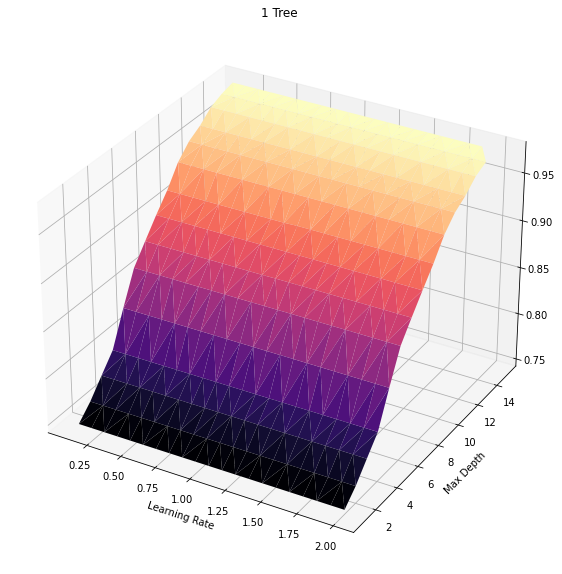

In [117]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][:314],
             list(zip(*hyperparameter_combo))[2][:314],
             val_acc_list[:314], cmap='magma')
ax.set_title('1 Tree')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0, 'Max Depth')

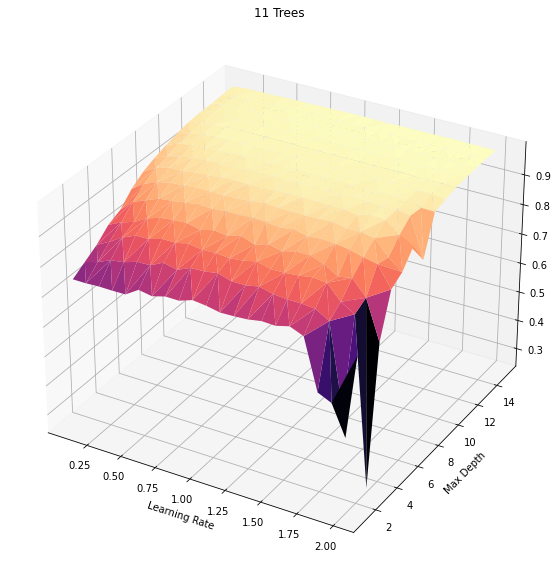

In [118]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][3464:3779],
             list(zip(*hyperparameter_combo))[2][3464:3779],
             val_acc_list[3464:3779], cmap='magma')
ax.set_title('11 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0, 'Max Depth')

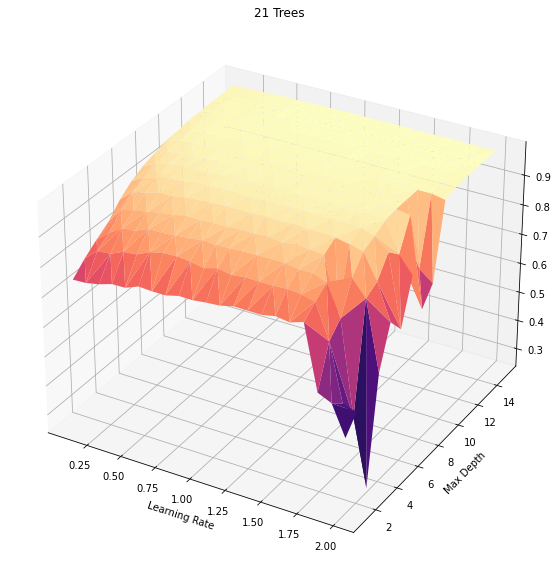

In [119]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][6614:6929],
             list(zip(*hyperparameter_combo))[2][6614:6929],
             val_acc_list[6614:6929], cmap='magma')
ax.set_title('21 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0, 'Max Depth')

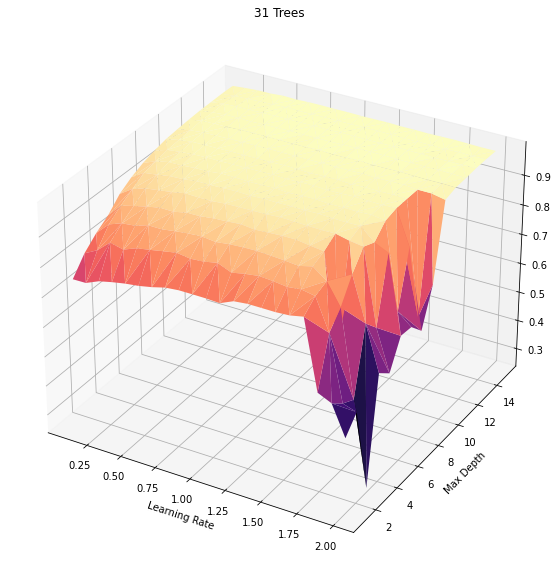

In [120]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][9764:10079],
             list(zip(*hyperparameter_combo))[2][9764:10079],
             val_acc_list[9764:10079], cmap='magma')
ax.set_title('31 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0, 'Max Depth')

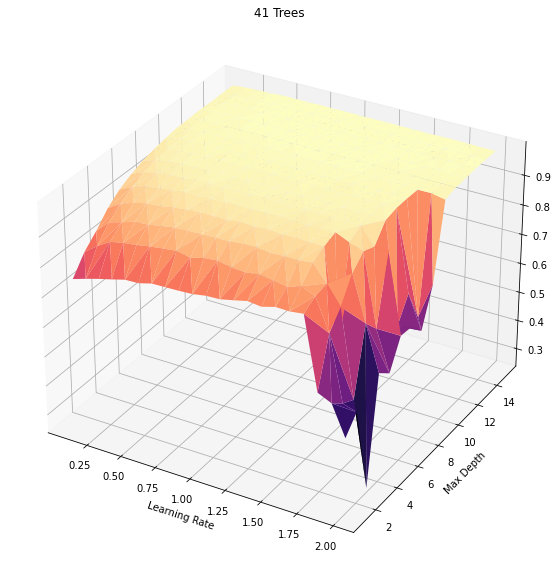

In [121]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][12914:13229],
             list(zip(*hyperparameter_combo))[2][12914:13229],
             val_acc_list[12914:13229], cmap='magma')
ax.set_title('41 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0, 'Max Depth')

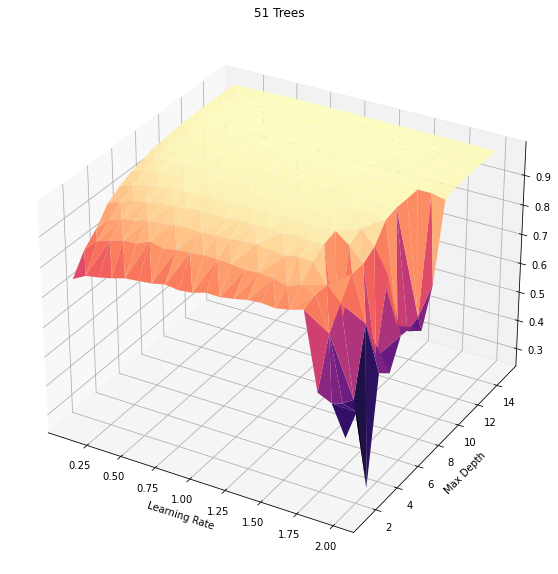

In [122]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][16064:16379],
             list(zip(*hyperparameter_combo))[2][16064:16379],
             val_acc_list[16064:16379], cmap='magma')
ax.set_title('51 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

In [125]:
print(np.max(val_acc_list), hyperparameter_combo[np.argmax(val_acc_list)])

0.9974529780564263 (55, 0.48, 14)


In [ ]:
# This model is quite a large step over previously computed random forest model
# that got a validation accuracy of 99.31%. Although there isn't much room to
# improve to begin with, an increase in validation accuracy of 0.44% is huge.

# The boosting performed quite well here with an accuracy of 99.75%.

Text(0.5, 0, 'Max Depth')

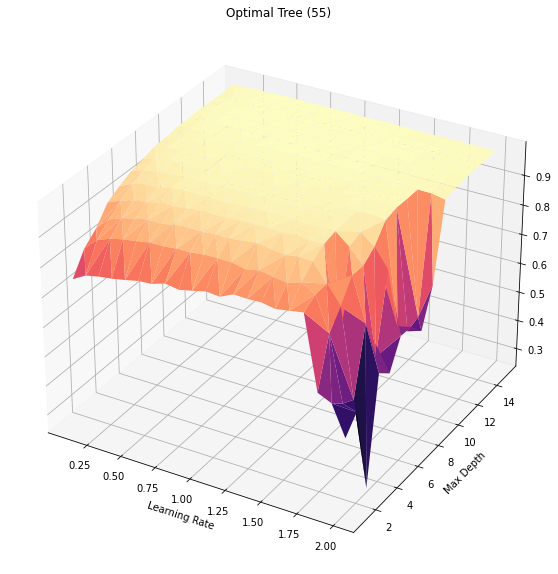

In [126]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][17324:17639],
             list(zip(*hyperparameter_combo))[2][17324:17639],
             val_acc_list[17324:17639], cmap='magma')
ax.set_title('Optimal Tree (55)')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

In [4]:
# since the dataset is too large for SVM, going to switch to downsampling for it
# rather than upsampling

real = jobdf[jobdf["fraudulent"] == 0]
fraud = jobdf[jobdf["fraudulent"] == 1]

real_downsample = resample(real,
             replace = True,
             n_samples = len(fraud))

data_downsampled = pd.concat([real_downsample, fraud])

X = data_downsampled.drop(['fraudulent'], axis = 1)
y = data_downsampled['fraudulent']

X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size = 0.7)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size = 0.5)

print(X_val.shape, X_test.shape, X_train.shape)
print(y_val.shape, y_test.shape, y_train.shape)


(259, 34) (260, 34) (1211, 34)
(259,) (260,) (1211,)


In [5]:
# cutting downsampled dataframes

X_train_cut = X_train.drop(columns = ['requirements_word_count',
                                      'benefits_word_count',
                                      'required_experience_word_count',
                                      'required_education_word_count',
                                      'avg_sentence_length_description',
                                      'avg_sentence_length_experience',
                                      'avg_sentence_length_company_profile',
                                      'avg_sentence_length_education',
                                      'avg_sentence_length_benefits',
                                      'description_num_suspicious_words',
                                      'employment_type_Contract',
                                      'employment_type_Full-time',
                                      'employment_type_Missing',
                                      'employment_type_Other',
                                      'employment_type_Part-time',
                                      'employment_type_Temporary'])

X_val_cut = X_val.drop(columns = ['requirements_word_count',
                                  'benefits_word_count',
                                  'required_experience_word_count',
                                  'required_education_word_count',
                                  'avg_sentence_length_description',
                                  'avg_sentence_length_experience',
                                  'avg_sentence_length_company_profile',
                                  'avg_sentence_length_education',
                                  'avg_sentence_length_benefits',
                                  'description_num_suspicious_words',
                                  'employment_type_Contract',
                                  'employment_type_Full-time',
                                  'employment_type_Missing',
                                  'employment_type_Other',
                                  'employment_type_Part-time',
                                  'employment_type_Temporary'])

X_test_cut = X_test.drop(columns = ['requirements_word_count',
                                    'benefits_word_count',
                                    'required_experience_word_count',
                                    'required_education_word_count',
                                    'avg_sentence_length_description',
                                    'avg_sentence_length_experience',
                                    'avg_sentence_length_company_profile',
                                    'avg_sentence_length_education',
                                    'avg_sentence_length_benefits',
                                    'description_num_suspicious_words',
                                    'employment_type_Contract',
                                    'employment_type_Full-time',
                                    'employment_type_Missing',
                                    'employment_type_Other',
                                    'employment_type_Part-time',
                                    'employment_type_Temporary'])



In [15]:
t0 = time.time()
svc = SVC(C=0.01, kernel='rbf')
cross_val_score(svc, X_train_cut, y_train, cv=10)
t1 = time.time()

print("Time to fit SVM: " + str(t1-t0) + "s")

Time to fit SVM: 0.5630230903625488s


In [13]:
print('rough time to fit 800: ' + str(((4.639019012451172*800)/60)))

rough time to fit 800: 61.85358683268229


In [16]:
# SVM (specifically SVC with a radial basis function as that's what scikit-learn uses)

# This is as many as my computer could handle as when running an SVM within
# python it sucks power faster than my computer can charge.

params_grid = [{'kernel': ['rbf'],
                     'C': np.linspace(0.1,20,40)},
                    {'kernel': ['rbf'], 'C': np.linspace(0.1,20,40)}]

svm_model = GridSearchCV(SVC(), params_grid, cv=10, n_jobs=7, verbose=4)
svm_model.fit(X_train_cut, y_train)


Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=7,
             param_grid=[{'C': array([ 0.1       ,  0.61025641,  1.12051282,  1.63076923,  2.14102564,
        2.65128205,  3.16153846,  3.67179487,  4.18205128,  4.69230769,
        5.2025641 ,  5.71282051,  6.22307692,  6.73333333,  7.24358974,
        7.75384615,  8.26410256,  8.77435897,  9.28461538,  9.79487179,
       10.30512821, 10.81538462, 11.32564103, 11.83589744, 12.34615385,
       12.8564102...
        5.2025641 ,  5.71282051,  6.22307692,  6.73333333,  7.24358974,
        7.75384615,  8.26410256,  8.77435897,  9.28461538,  9.79487179,
       10.30512821, 10.81538462, 11.32564103, 11.83589744, 12.34615385,
       12.85641026, 13.36666667, 13.87692308, 14.38717949, 14.8974359 ,
       15.40769231, 15.91794872, 16.42820513, 16.93846154, 17.44871795,
       17.95897436, 18.46923077, 18.97948718, 19.48974359, 20.        ]),
                          'kernel': ['rbf']}],
             verbose=4)

In [17]:
print('Best score for training data:', svm_model.best_score_)
print('Best C:',svm_model.best_estimator_.C)
print('Best Gamma:',svm_model.best_estimator_.gamma)

Best score for training data: 0.710967348597751
Best C: 18.97948717948718
Best Gamma: scale


In [18]:
final_model = svm_model.best_estimator_
pred = final_model.predict(X_val_cut)

print(confusion_matrix(y_val,pred))

[[100  28]
 [ 36  95]]


In [20]:
accuracy_score(y_val, pred)

0.752895752895753

In [ ]:
# The SVM performed terribly in comparison to the other models so we will scrap this
# model and instead go with the gradient boosting model which got an accuracy of
# 99.75% on the val set rather than an accuracy of 75.29%.

In [22]:
# Using the test set on best performing model: Gradient Boosting

# reformatting the data back to upsampling

real = jobdf[jobdf["fraudulent"] == 0]
fraud = jobdf[jobdf["fraudulent"] == 1]

fraud_upsample = resample(fraud,
             replace = True,
             n_samples = len(real))

data_upsampled = pd.concat([real, fraud_upsample])

X = data_upsampled.drop(['fraudulent'], axis = 1)
y = data_upsampled['fraudulent']

X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size = 0.7)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size = 0.5)

print(X_val.shape, X_test.shape, X_train.shape)
print(y_val.shape, y_test.shape, y_train.shape)

X_train_cut = X_train.drop(columns = ['requirements_word_count',
                                      'benefits_word_count',
                                      'required_experience_word_count',
                                      'required_education_word_count',
                                      'avg_sentence_length_description',
                                      'avg_sentence_length_experience',
                                      'avg_sentence_length_company_profile',
                                      'avg_sentence_length_education',
                                      'avg_sentence_length_benefits',
                                      'description_num_suspicious_words',
                                      'employment_type_Contract',
                                      'employment_type_Full-time',
                                      'employment_type_Missing',
                                      'employment_type_Other',
                                      'employment_type_Part-time',
                                      'employment_type_Temporary'])

X_test_cut = X_test.drop(columns = ['requirements_word_count',
                                    'benefits_word_count',
                                    'required_experience_word_count',
                                    'required_education_word_count',
                                    'avg_sentence_length_description',
                                    'avg_sentence_length_experience',
                                    'avg_sentence_length_company_profile',
                                    'avg_sentence_length_education',
                                    'avg_sentence_length_benefits',
                                    'description_num_suspicious_words',
                                    'employment_type_Contract',
                                    'employment_type_Full-time',
                                    'employment_type_Missing',
                                    'employment_type_Other',
                                    'employment_type_Part-time',
                                    'employment_type_Temporary'])



(5104, 34) (5105, 34) (23819, 34)
(5104,) (5105,) (23819,)


In [23]:
# applying to Gradient Boosting

boost = GradientBoostingClassifier(n_estimators= 55,
                                   learning_rate= 0.48,
                                   max_depth= 14,
                                   random_state=0).fit(X_train_cut, y_train)
boost.score(X_test_cut,y_test)


0.9958863858961802

In [ ]:
# when applied to the test set, the gradient boosting model obtained an accuracy of
# 99.59%. This is an extremely good model all things considered. Now that we have
# obtained a great model, let's test the data on neural networks.